# Research Question No. 5
This research question aims to investigate the characteristics of groups of bugs for which classifiers yield better accuracy.

# 1. Experimental parameters


| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| Project                    |        Eclipse, Freedesktop, Gcc, Gnome, Mozilla, WineHQ       |
| Algorithms                 | NN |
| Metrics                    | Accuracy |
| Features                   | Long Description |
| Number of Terms            |        100       |
| Balancing                  |        Smote   |
| Resampling                 |        Repeated CV 5 x 2       |
| Threshold                  |        365       |








Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

# 2. Setup environment

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import os 
import matplotlib.pyplot  as plt 
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns 
from wordcloud import WordCloud
from scipy.stats import friedmanchisquare
from scipy.stats import kruskal

# Setup Matplotlib
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
%matplotlib inline 

# Setup Seaborn
sns.set_context("paper")
sns.set_style("ticks")

pd.set_option('display.max_columns', None)

results_gcc_path = "datasets/20190926143854_rq4e4_gcc_tests_balanced_acc.csv"
reports_gcc_path = "datasets/20190917_gcc_bug_report_data.csv"

results_eclipse_path = "datasets/20190926143854_rq4e4_eclipse_tests_balanced_acc.csv"
reports_eclipse_path = "datasets/20190917_eclipse_bug_report_data.csv"

print("Setup complete")

Setup complete


# 3. Load data

In [3]:
    !echo "\nHeader of metrics file $reports_gcc_path"
    !head -n 2 $reports_gcc_path

    !echo "\nNumber of lines in the file $reports_gcc_path"
    !wc -l $reports_gcc_path
    
    !echo "\nHeader of metrics file $results_eclipse_path"
    !head -n 2 $results_eclipse_path

    !echo "\nNumber of lines in the file $results_eclipse_path"
    !wc -l $results_eclipse_path

\nHeader of metrics file datasets/20190917_gcc_bug_report_data.csv
bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
CLASSPATH-26758,2006-03-19,awt,CLASSPATH,GdkFontPeer.getPostScriptFontName unimplemented,The Openstreetmap applet expects java.awt.Font.getPSFontName() to return something non-null.,unassigned,roman,fixed,1,resolved,4,2006-05-20,0,12,2006-05-20,62,normal,2
\nNumber of lines in the file datasets/20190917_gcc_bug_report_data.csv
489575 datasets/20190917_gcc_bug_report_data.csv
\nHeader of metrics file datasets/20190926143854_rq4e4_eclipse_tests_balanced_acc.csv
bug_id,bug_fix_time,long_lived,y_hat
4DIAC-489747,139,Y,N
\nNumber of lines in the file datasets/20190926143854_rq4e4_eclipse_tests_balanced_acc.csv
2409 datasets/20190926143854_rq4

In [4]:
# read data.
reports_gcc_data  = pd.read_csv(reports_gcc_path)
rows_and_cols = reports_gcc_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {reports_gcc_path}.\n")

results_gcc_data = pd.read_csv(results_gcc_path)
rows_and_cols = results_gcc_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {results_gcc_path}.\n")


reports_eclipse_data  = pd.read_csv(reports_eclipse_path)
rows_and_cols = reports_eclipse_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {reports_eclipse_path}.\n")

results_eclipse_data = pd.read_csv(results_eclipse_path)
rows_and_cols = results_eclipse_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {results_eclipse_path}.\n")


There are 10000 rows and 19 columns in datasets/20190917_gcc_bug_report_data.csv.

There are 2480 rows and 4 columns in datasets/20190926143854_rq4e4_gcc_tests_balanced_acc.csv.

There are 10000 rows and 19 columns in datasets/20190917_eclipse_bug_report_data.csv.

There are 2408 rows and 4 columns in datasets/20190926143854_rq4e4_eclipse_tests_balanced_acc.csv.



# 4. Test Results Analysis

### 4.1 Review data

In [5]:
results_gcc_data.head()

,bug_id,bug_fix_time,long_lived,y_hat
0,CLASSPATH-16983,15,N,N
1,CLASSPATH-17008,342,N,N
2,CLASSPATH-17060,337,N,N
3,CLASSPATH-18312,5,N,N
4,CLASSPATH-21635,96,N,N


In [6]:
reports_gcc_data['bug_class_observed']  = reports_gcc_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')

In [7]:
reports_gcc_data[['bug_fix_time', 'bug_class_observed']].head()

,bug_fix_time,bug_class_observed
0,62,short-lived
1,2,short-lived
2,1089,long-lived
3,11,short-lived
4,62,short-lived


In [8]:
results_eclipse_data.head()

,bug_id,bug_fix_time,long_lived,y_hat
0,4DIAC-489747,139,Y,N
1,4DIAC-495630,38,Y,Y
2,4DIAC-500078,38,Y,Y
3,4DIAC-511266,0,N,N
4,4DIAC-518907,200,Y,N


In [9]:
reports_eclipse_data['bug_class_observed']  = reports_eclipse_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')

In [10]:
reports_eclipse_data[['bug_fix_time', 'bug_class_observed']].head()

,bug_fix_time,bug_class_observed
0,0,short-lived
1,177,short-lived
2,1,short-lived
3,50,short-lived
4,264,short-lived


## 4.2 Results analysis

In [11]:
results_gcc_merged_data = pd.merge(
    reports_gcc_data,
    results_gcc_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)
results_gcc_merged_data = results_gcc_merged_data[results_gcc_merged_data.long_lived == 'Y']
results_gcc_merged_data.loc[results_gcc_merged_data.long_lived == 'Y', 'status_prediction'] = results_gcc_merged_data['y_hat'].apply(lambda t: 'True Positive' if t == 'Y' else 'False Negative')


In [12]:
results_gcc_merged_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,bug_class_observed,long_lived,y_hat,status_prediction
0,GCC-43804,2010-04-19,target,GCC,[4.6 regression] ICE in reload_cse_simplify_op...,$ gcc/xgcc -Bgcc/ -O2 -fpic -S memusage.i \nme...,rsandifo,schwab,fixed,1,resolved,4,2013-04-12,0,29,2013-04-12,1089,normal,2,long-lived,Y,N,False Negative
4,GCC-560,2000-09-21,target,GCC,[Solaris 8 x86] static code segfaults before main,If you compile static code any code with gcc o...,unassigned,rami.lehti,fixed,1,resolved,4,2003-07-25,0,2,2003-07-25,1037,normal,2,long-lived,Y,Y,True Positive
9,GCC-8340,2002-10-24,target,GCC,ICE on x86 inline asm w/ -fPIC,From: Glen Nakamura \nTo: gcc-gnats@gcc.gnu.or...,ebotcazou,glen,fixed,1,resolved,4,2014-10-13,0,10,2014-10-13,4372,normal,2,long-lived,Y,N,False Negative
11,GCC-65757,2015-04-13,libquadmath,GCC,gfortran gives incorrect result for anint with...,gfortran gives an incorrect result for the ani...,jvdelisle,bugs,fixed,1,resolved,4,2019-03-01,0,26,2017-09-16,887,normal,2,long-lived,Y,N,False Negative
12,GCC-2434,2001-03-30,target,GCC,Compilation with large file support (solaris &...,When compiling C++ programs using the flags fo...,unassigned,pnobili,fixed,1,resolved,4,2003-07-25,0,5,2003-07-25,847,normal,2,long-lived,Y,Y,True Positive


In [13]:

results_eclipse_merged_data = pd.merge(
    reports_eclipse_data,
    results_eclipse_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)
results_eclipse_merged_data = results_eclipse_merged_data[results_eclipse_merged_data.long_lived == 'Y']
results_eclipse_merged_data.loc[results_eclipse_merged_data.long_lived == 'Y', 'status_prediction']  = results_eclipse_merged_data['y_hat'].apply(lambda t: 'True Positive' if t == 'Y' else 'False Negative')

In [14]:
results_eclipse_merged_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,bug_class_observed,long_lived,y_hat,status_prediction
0,EQUINOX-259283,2008-12-18,p2,EQUINOX,[engine] Need a data area for actions,Currently we're persisting some data in the pr...,simon_kaegi,simon_kaegi,fixed,1,resolved,4,2009-01-21,0,2,2009-01-21,34,normal,2,short-lived,Y,Y,True Positive
1,Z_ARCHIVED-58853,2004-04-16,Hyades,Z_ARCHIVED,Imported Log Correlatior sample project has pr...,Found in Hyades 3.0 20040416_1005 driver.\n\nS...,apnan,shiah,fixed,1,closed,6,2012-02-15,0,6,2004-04-22,6,normal,2,short-lived,Y,Y,True Positive
2,PLATFORM-4902,2001-10-11,Team,PLATFORM,Project out of sync after release (1GKS577),Sometimes after a release the project stays ou...,valentam,valentam,fixed,1,resolved,4,2002-03-21,0,3,2002-03-21,161,normal,2,short-lived,Y,Y,True Positive
3,BIRT-83104,2005-01-18,Report,BIRT,Patch to add files to cvsignore,Attached patch adds the bin directory and lib/...,Birt-Data-inbox,thierry.lach,fixed,1,resolved,4,2005-12-21,0,5,2005-01-25,7,trivial,1,short-lived,Y,Y,True Positive
4,VIRGO-337233,2011-02-15,runtime,VIRGO,Browsing the OSGi state in the Admin Console b...,To Reproduce:\n\n1. In the OSGi state tab sele...,virgo-inbox,eclipse,fixed,1,closed,6,2011-05-09,0,4,2011-05-09,83,major,4,short-lived,Y,Y,True Positive


In [153]:
def plot_bar (project, data, column, n):
    
    top_g = data.groupby(column)[column].agg(['count'])
    top_s = top_g.sort_values('count', ascending=False).head(n)
    top_n = data.loc[data[column].isin(top_s.index)].groupby(column)['status_prediction'].value_counts(normalize=True).unstack()
    
    plt.figure(figsize=(20,20))
    fig, axis = plt.subplots(figsize=(10, 10)) 
    
    primary   = top_n.plot(kind='barh', stacked='True',  color=["tab:red", "tab:blue"], ax=axis)
    secondary = primary.twinx()
    
    labels = [i.get_text() for i in primary.get_yticklabels()]
    labels_new = [top_s.loc[top_s.index==i, 'count'].values[0] for i in labels]
    
    primary.set(xlim=(0, 1))
    primary.set_xlabel('percentage', fontsize=MEDIUM_SIZE)
    primary.set_ylabel(column, fontsize=MEDIUM_SIZE) 
    primary.set_title(project, fontsize=BIGGER_SIZE)
    primary.tick_params(axis="y", labelsize=MEDIUM_SIZE)
    primary.tick_params(axis="x", labelsize=MEDIUM_SIZE)
    
    secondary.set_yticks(primary.get_yticks())
    secondary.set_ylim(primary.get_ylim())
    secondary.set_yticklabels(labels_new)
    secondary.tick_params(axis="y", labelsize=MEDIUM_SIZE)
      

### Reporter Name

### GCC

<Figure size 1440x1440 with 0 Axes>

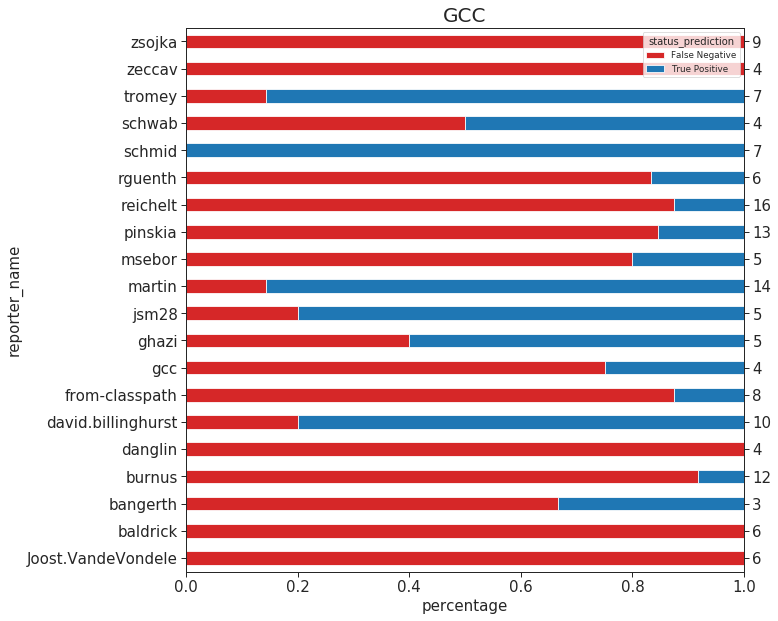

In [155]:
plot_bar('GCC', results_gcc_mergdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAwoAAAJtCAYAAACWvod3AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzdd3hUZdrH8W8CAYIEaYJIERS4sYFdUAFF195RrLDYUHeFRbGLSBVdC+xa8VUQWEQUxb4qCiooorKIlVujSC8KIqKUkOT945zgMDMhbcgE5ve5Lq7JPOcpd2Jyee55yknLz89HREREREQkUnqyAxARERERkYpHiYKIiIiIiMRQoiAiIiIiIjGUKIiIiIiISAwlCiIiIiIiEkOJgoiIiIiIxFCiICIiIiIiMSonOwAREZHyZmatgKuBY4BmQBbwG/AdMB2Y4O6z47SrAnQDzgEOBuoAm4DvgXeBUe7+eaLaiYgkU5oeuCYiIqnCzNKA/uG/dOB/wMfAaoJkoQ3QHqgCXOvuD0e0bQW8COwD/AxMARaGdfclSDqqAGe5+8tlbScikmyaURARkVTSHxgALAIudPcPoiuYWX2gD7BrRFkD4B2gMTACuM3d18dpdydQu6ztREQqAs0oiIhISjCzvQAH8oCD3f2rIupXdvfN4df/B1xBsCTpoiLaVXX3jWVpJyJSEShREBGRlGBmg4F+wNPufnEJ2mUCvwBVgdbu7tuznYhIRaFTj0REJFUcFb5OLWG7Qwlu9peU8Ga/tO1ERCoE7VEQEZFUsXv4uiT6gpk1A3pEFa9x9xFAw/D94hKOV9p2IiIVghIFERFJFWnha7w1t80INhRHWkCwAXlb7Uo7nohIhadEQUREUsUyoDXQKPqCu79LeGNvZpWBnIjLS8PXxiUcr7TtREQqBO1REBGRVFFwFOpxJWz3KbARaGxmVg7tREQqBCUKIiKSKp4CNgPnmtk+xW0UPvdgXPj2jqLqm1nVsrQTEakolCiIiEhKcPfvgSEET0H+r5kdWUjVWnHK+hFsSr7YzO4Njz7dipnVM7N/AxckoJ2ISNLpOQoiIpIyzCyNYNPyHQQfls0GPgZWEyQIzYDjCY41Hefu3SPatgJeBPYBfgKmAAsJEo99gGPCdme5+ytlbScikmxKFEREJOWEewauBo4lSA52AX4DvgdmECQJ/4vTrgrQDegCHATUJdiH8CMwDfg/d/8iUe1ERJJJiYKIiIiIiMTQHgUREREREYmhREFERERERGIoURARERERkRhKFEREREREJIYSBRERERERiVE52QGIlAcz0/FeIiIissNw97Rkx6BEQVKGuyc7BBEREZEiBY96ST4tPRIRERERkRhKFEREREREJIaWHomIiIiksHXr1rFy5UrS0pK+JD4lZWRksMcee5CeXvE+v1eiICIiIpLCVq1aRZMmTcjIyEh2KClp7dq1LF26lMaNGyc7lBgVL3URERERkXKTl5enJCGJatasSU5OTrLDiEszCpIyclasTHYIIiIiFU5+Tg55FfRGNVXk5+RUyPsUJQpSrszsKWB/dz80fN8DGA1kufu67Tl2dqdO27N7ERGRHVL+3cPYuGlTssNIaRuys8m+5dYStzOzs4BBgAFLgQfd/YFExaWlR1LeBgM9kh2EiIiIlNx/Xn2V9Rs3Jqxesnzy5Zf0uusuAN795BNGvfBCoXXX/v47E994Y8v7latXc8O99273GItiZkcBLwAfA6cDo4B7zKxPosZQoiDlyt2/d/cvkx2HiIiIlNz4V19lQzESgOLWS6T8/Hzy8vJK3O6Yww7jsnPOKfT6b7//zrMRiUL9OnW478YbSxVjgvUHZrj7Fe7+lrsPBh4E+ptZlUQMoKVHsoWZNQPmF3L5WGAzMAxoG5b9AAx19+fC9pWAO4DLgAZAdnj96YgxniJi6VEhcdxIMPPQ1d1fNrP2wK3AocCuwHfAve4+vnTfqYiIiBRl/YYN3Hj//axctYrcvDz+cuSR/PTLL1x5553UysriiUGDGDpyJF99/z0bNm7k+Pbt+dsFF/D0a6/F1Gt/8cXMHB/8b3vKzJm8/+mnDO7Vi7c+/JCRzz5LpfR0alSvzqghQ+LG8tLUqUz7+GM25eSwZOVKTu7Qgau7dmXJypVcO2QIh+6/P59/+y3Db7qJH5cu5bGJE9mUk0Pj3Xdn0N//TvXMTD6YM4d7R42iVs2a7LPXXlv1/fX333PrlVeyas0ahowcyZIVKwC4rWdPJrz+OotXrKBr3760a9OG808+md533cXzI0awcdMmhj7+OF9//z2VKlXihr/+lcMOOICXpk7lvU8/ZcPGjSxavpzORxzBdd27J/o/0YHAw1FlbwHXAe2B98o6gBIFibSM4BcrUl/gNOAXgl+4lwjWwqUBBwC1IuoOAm4CBgKfAF2A8WaW7+4TihOAmd1BkBSc6e5vhsV7Ah8AjwEbgKOA0WaWV9x+RUREpGQ+mDOH3erU4aHbbweCT9ZfmjqV/xs4kNo1awJw7UUXsWtWFrm5ufQcOJBvf/yRi049lXGvvLJVvcI8/txzPHLHHTSoW5e1v/++zbpffvcdk0aMoFqVKlx88810OPhgatWsyY9LlzLw2mu5vWdPflm7licmTWLknXeSWa0aoydPZtwrr9DjrLMY9OijPD5gAE0bNuSm+++PO8Y9Tz7JIfvtx/CbbyY3N5c/Nmyg9yWXkL1wIc+GbZas/HPTccGSpEnDhzN/8WKuGTyYlx58EACfP59n7ruPKhkZnNWrFxeecgq716tXjJ98sVUDojeXFEzj7IMSBUkkd98IfFTw3sxOA84hmCHIIPg0/1p3/y2s8lZE3TpAH2CIuxd8HPCmmTUGBgBF3tCb2V1AL+AUd383Iq5nIuqkAe8DjYEr4/VrZgOAO4saT0RERArXcs89eWDsWEaMG0fHQw7h4H33janz1ocf8vyUKeTm5vLzmjX8sHgxrZo1K/YYB7ZuTf+HHuKEI4/kuHbttlm3Xdu21MrKAuC4I45gzrx5HHv44TTcbTfatGoFwBfffssPixfz1zC52bx5M21atWL+kiU0ql+fPffYA4BTO3Xi+SlTYsb45MsvGdK7NwCVKlUia5ddtpnAzPnmGy485RQAmjduTMPddmPB0qUAHN6mDVm77ALAXk2asOynn0qUKJhZflTRQHcfEPE+Gzgsqs7h4WudYg+0DUoUJC4zawX8B3jM3ceYWW1gHfC0mT0BvOfuayKa7A9UB56L6moi8JSZ1Xf3bZ379QDQFTjR3T+MiqU2wSzFmUAjoFJ4aUm8jsI/ogFRfUT/sYmIiMg27LnHHkz45z+Z8b//8e/x42nftu1W15esWMHYl19m/D33ULNGDe548MFCT0+KfObzpog6/a66ii++/Zbps2dzft++TLz//i3JQGwnWz85uuBdZtWqW8ry8/Np16YNd19//VZ1582fv12ePJ2fX/jtRZXKf95mp6enszk3t0R9u3tRAT8GPGpmVwKTCJKEvuG1kg1WCG1mlhhmlgW8CHxFMEuAu/8CnEAws/As8JOZvWZmBYv8GoavK6K6K3hfu4hhuwCzCXbuR3sKOB+4N4zhMIKd/dWK9x2JiIhISa1cvZpqVatyaqdOdD/jDL754Qd2yczkj/XrAVi3fj2ZVatSo3p1Vq1Zwwdz5mxpG1kPoG6tWvyweDF5eXlMnTVrS/mi5cs5oFUr/nbhhdSqWZPlP/9caDyz5s7l199+Y8PGjUz7+GMObN06ps4BrVrxmTsLly0DYP3GjSxYupTmjRqxZOVKFi1fDsAb06fHHePwAw7g2TeDlc+5ubms++OPmO8l0iH77svr778PwIKlS1n+0080a9So0O8hwUYRJgvAaoITkAaF16Lvx0pFMwqylXBpzxiCG/vj3H3LE1jcfSZwkpllAscTzAI8DbQj2N8AUB9YFdFlg/B1dRFDnwa8Cow1s0vcPS+MpxpwKsGSp8ci4lSSKyIish1lL1jA8LFjSUtPp3KlStzesyeff/stfx8yhHq1a/PEoEFY8+Z06dOHRg0abHXj3uUvf9mqXu9LLqH3XXfRoF49WjRpwh8bNgAwfOxYFi5bRn5+PocfcAC2jWVLB7Zuze3//jeLli/n5A4d2K9Fi632CwDU2XVXBl17LbcMH77lacd/v+gi9txjD+64+mp6DR1KrZo1Oah1a7IXLYoZ46bLLmPwY4/x4jvvkJ6ezu09e9LWjLatW9OlTx+OOuggzj/55C31u550EkNGjuTc666jUqVKDLr2WqqU01Ou3T0XuDbc39mY4ECagv8IHxXasATStjVlIqkn/GW7A+js7jOKqHsrcKu71wz3KCwC7nH3QRF1XgNauLuF75+ikAeuAfsCbwPPuHvP8PquwBrgMncfHZZlAT8C+e5erMV+Zpb/YppyCxERkWj5dw+jeYsWyQ5jmyJPJtoZzc/OJi3igWtn5ecVZ+lRDDMbBZi7H5WIuDSjIFuY2dEEewFGA5vNLHJXUQOgO8GSpIUEewWuAqYCuPtqMxsB9DOzzcCnBBuhTwEuLM747v5xuIH6DTNb6+43uPuvZvYJwZnAa4E84BbgV2DbRymIiIiI7KTC+7Sjgc8I7okuBE4MyxJCiYJEakGwN+iy8F+kq4F84C6C5UU/ESwVui2iTn+CZy1cw5/PUbgk8tSiUKHTWO7+vpmdA7xkZr+5+0DgIuBxYCzBsqaHCDZOX1uK71FEREQqqA/nzGHEf/6zVVmj+vUZfvPNnNm5c5KiqrByCPZwDiD4IHU6cJS7f5GoAbT0SMqVmT0P1HD3E8t53Pwv34+/cUlERCSVLfp1Dc2aN092GCntx/nzabLrn4+m2r9jh1ItPUo0zShIuQiPOO0IHEOwQ7/cZTSon4xhRUREKrS0P34nvZw24Ep8aRkZFfI+Rbs7pbx0Inguwwwg/uMQRURERKTCUKIg5cLdX3T3LHc/092LOipVREREdlKLFy/miCOOoFu3bnTr1o2JEycWWrdbt26sXl2624YHH3yQzp07bzkm9cEHH+SNN94oVV/RZs2aRXZ29pb3t9566zZq77i09EhEREREANi8Zg35G+M/Xbkk0qpWoXKtWoVeP/DAAxk5cmSZxynKLrvswksvvcS5556b0H4//vhjWrZsSYvwWNlhw4YltP+KQomCiIiIiACQv3ET2Z06lbmfFu+9V6L6q1ev5oYbbtjy6f+IESOoW7fulutz585l6NChVK1alSZNmnDXXXcxb948hg0bRl5eHs2bN2fgwIGkpW29/7dbt248/fTTnH322VuVv/baa4wfP568vDy6dOnCeeedx7x58+jXrx916tRh1113pXXr1lx++eXccsstLF26lHXr1tGvXz9atmzJ5MmTyczM5Nlnn2XUqFGcdtppvPjii3Tt2pVJkyaRnp7O6NGjqVmzJqeffjp33nknS5YsAWDw4MHsueeepfmxljstPRIRERGRcvXZZ59tWXr0zTffkJWVxciRIxk3bhynnnoqzz///Fb13333Xa644grGjRvHkCFDABg6dCj33Xcf48aNo3r16syYEfuc2Jo1a3LUUUfx+uuvbylbs2YNEyZMYNy4cTz99NNMnjyZdevWMXz4cIYMGcLjjz9ORsTm7v79+zN27Fjuu+8+Hn74YbKysjj77LPp1asXo0aN2lKvcuXKHHTQQcyaNQuAt956ixNPPJFJkyaxzz77MHbsWG6//Xb+9a9/JfRnuT1pRkFEREREylX00qOff/6ZgQMH8ssvv/Dbb79x6KGHblW/W7duPPLII7z11lscccQRnHfeeXz33Xdcf/31APz++++0bNky7liXXnopPXv2pGPHjgAsXLiQBQsW0KNHDwDWrl3LihUrWLp0Ka1btwbggAMO4I8//iA3N5cRI0bw1VdfkZ6ezpo1a7b5fZ1xxhk888wz1K9fn913350aNWrw3XffMXfuXKZMmQJAZmZmyX9gSaJEQURERESS6pVXXuGwww6je/fujB8/nu+//36r69WrV6dfv34AnHjiiZx55pm0atWKESNGUKdOHYAty5ai1alTh4MPPpgpU6bQqlUrmjRpwt57782oUaNIT08nJyeHjIwMGjVqxLx582jdujVffPEFe++9N/PmzWPp0qWMHz+e7Oxs+vTpA0BGRga5ubkxY7Vt25ZBgwbx3HPPcfrppwPQokULzIwLLrgAgE2byr4HpLwoURARERGRpGrfvj033ngjH3zwAQ0aNKBy5a1vUSdOnMjbb7/N5s2b6dChA1WqVOG2226jb9++bN68mfT09C37B+K5/PLLmTBhAgC1a9ema9eudOvWjfT0dKpVq8bIkSPp06cP/fr1o1atWtSoUYOMjAyaN2/OmjVr6N69OwcddNBW8d59991MnTqV++/f+tT3Y489lgkTJtC3b18AzjvvPAYOHLhl+VPnzp23zGZUdHoys6QEM8t392SHISIiUuHMnz+f5uGTmcvr1KOKqGBmAeCWW27h5JNPplMCNnYXR+R/AwAz05OZRURERKTi2NFu7hPpm2++4a677iIvL49mzZrRoUOHZIeUdEoURERERCTltWnThmeeeSbZYVQoOh5VRERERERiaEZBUkbOipXJDkFERKTCyc/JIa+QE4OkfOTn5FTI+xQlCpIyEvGkSRERkZ1N/t3D2LgDHdm5M9qQnU32LbeWqQ8zawQ4sAuQ5e7ryhqXlh6JiIiIiOz47gXKnBxE0oyCiIiIiACwfvcmbEor++fIVfLzyFy+KO61nJwcrh48GACfP5+9mzShcuXKXNGlC+3bti3TuC+8/TajJ0+mft26AAzp1YuGu+1WrLYrVq3iuTff5NqLLuKdjz6irRn1atfeqryiMrMOwEnAXQQJQ0IoUUhhZtYMmF/I5WPd/V0zOxO4A9gfWAOMBW539y2LGc2sDTAU6EDwO/V1WGdKeL0uwS/uGUBtYAHwqLuPCK/3BS4AWgEbgI+B69w9O7w+ELgK2MPd8yLGPQ14BWhZUFdERERKb1NaOu3ufb/M/Xx0Y0cyC7mWkZHBk4MGAXB5//7cd8MN1K5Zc8v13NxcKlWqVOqxzz/5ZC457TRee+89nnrxRW698spitWtQt+6WZOCdWbNo1KAB9WrX3qq8IjKzSsCDwCCCe7WEUaKQ2pYB7aPK+gKnAYvMrCswARgJ3AbsDQwjWLJ2A4CZtQY+IFgTdzWwCjgUaBJezwTeBeoDA4F5QIvwX4HGwEMECUTNsJ8PzKyVu/8KPAP0BzoB0yLadQVmK0kQERHZ8Z3zj39w5IEH8u2CBVx29tm8P3s2N112GZtzc7noppt49v77WbJyJXc9/jibcnKoXbMmQ3r3pkr4kLRo1rw5b37wAbm5uQx45BGWrFhBeno6/a+5hqYNG9L/oYdYvHw5AH26d6dWVhYPjBlDr4sv5qO5c/lxyRJaNG3KFV268MCYMfS/5hpuGT6cxwcMAGDo449z8tFHs3eTJgx89FF++/13qlapwpDevamVlVVePzYI7puqAQ8DFyeyYyUKKczdNwIfFbwPP6E/B7gM+AGYCox1979F1NkIPGxmw9x9FXAn8CvQwd3Xh9WmRAzTHdgPONjdPwvLpkbFcV1E/5XC9iuBM8PxvzGzz4HzCRMFM6saXh9cph+CiIiIVAi/r1/PWccdR4umTflo7ty4dYaPGcN13bvTomlTxr3yCq+99x5nH3983LqzPv+c5o0b886sWdSsUYPBvXrx2bx5/Hv8eIb27s33ixYxbtgw0tPTycvLY/GKFQDs3aQJ7dq2pfsZZ9C6eXMWLlsGQJ1dd6VKRgZLV65ktzp1+Co7m9uuvJIHxozh7OOOo8MhhzB11izGv/oqf7/wwu3zQ4oSrtoYDFzi7jlmltD+lSgIAGbWCvgP8Ji7j7HgN60p8KyZRf6eTCXIWvcH3gM6A/+JSBKidQbmRCQJ8cZuR/BLfjBQJ+JSq4ivJwLXmdm17r4ZOBnIAp6N098AggRGREREdhDVq1WjRdOmAKSlpW0pz8/P3/L1D4sXM+yJJwDYtGkTnQ47LKafif/9L9M+/pjdatXiliuv5Lk336RNq+CWok2rVixctoyqVarQ7fTTuePBB6lWtSpXde1arBhP7tCB16dPp2XTprRv25a0tDSyFy7ki+++46mXXiI3N5eWe+5Z6p9BJDPLjyoa6O4DosqGArPc/fWEDBpFiYJgZlnAi8BXQJ+wuF74WtgvXpPwtS7BEqbCbPO6mTUF3iLYl3AVsBTYBLxGkJAUeIbgj6FzWP98YKa7L4zuM/wjGhA1TvQfm4iIiFQg6el/bqKuWaMGK37+GYCvsv9cYdysUSP6dOtG04YNgWBjdLSCPQoFmjZsyOfffsuJRx3F599+S9Pdd2dzbi7HtWvHSUcfzcvTpjHpzTc57ZhjtrTJqFyZ3NzcmL47H3EEV/Tvz3cLFmxJLvZq0oSOhxzCEW3aFBpTabh72raum9l+BKtAOppZrbC4evi6q5nlbuOD3GJRopDizCwNGEOwyfi4iE3Kq8PXnsCcOE0LNkGvAhpuY4hVbL0fIdpJBL/UZ7r772FMldl6ZgF3/8HMPgXON7MZwOkE+yZERERkJ9O6eXNy8/K48s47OWiffbaU9+3Rg7ufeIINGzcCcFXXrhy6337b7Ov4du2YPns2l/brR3paGv2vuYbf//iD6++9lzQgZ/Nmbu/Zc6s2HQ4+mAfGjmWf5s3petJJW8ozq1aleaNG/Lh0KXs1bgxAz3PPZfDIkTzx/PMAnHvCCZx41FGJ+DEUpSWQAcyMc20x8CRwRVkGSIuczpHUY2Z3EJxq1NndZ0SUpwMLgTHufvs22j9NcNpRS3ffEOd6T+Ax4EB3/zzO9X8QHOOVFe6ZwMwuAsYD97v7DRF1+wK3A70ITl9q7O7bms2IHCf/xQQc9yYiIrKzyb97GM1bBJ/plcfxqBJrfnY2aREPXDsrP684Mwr1CJaCRzoJuBk4BfjB3b0scWlGIYWZ2dEEJxGNBjaHewUKfE1wAtI4M6sJ/JdgSdBewFnAue7+R9j+E+B9M7ufYAbhIGCVu48iuKH/O/BWuHfAgeZAK3e/hWDPQyVgtJk9SbDx+QbiH+/1LEFScS/wfnGTBBERESmezOWLCj3WVCoWd/+Z4GTJLcKj7wGm68nMUlYtgDSC9W0zo/4d7O4TCU4WOhB4DngB+BvwP4KkgTBTPRr4GXgCmAycS3DUKeEsQ2eC5x0MIkg4biLYi4C7fwFcChwBvApcBJxHcJLSVtx9EfAhwVKnZxL4cxARERGRKFp6JCnBzPK/fH96ssMQERGpcBb+uobmzZsnO4yUNv+H+TStVWvL+/07dihy6VF50NIjSRkZDeonOwQREZEKp/KG9eQSPDFZyt/atWupukv1CnmfokRBREREJIXVrVuXRYsWbfXsAik/GRkZ7LHHHskOIy4lCiIiIiIprEaNGtSoUSPZYUgFpM3MIiIiIiISQ4mCiIiIiIjEUKIgIiIiIiIxlCiIiIiIiEgMJQoiIiIiIhJDiYKIiIiIiMRQoiAiIiIiIjGUKIiIiIiISAwlCiIiIiIiEkOJgoiIiIiIxKic7ABEykvOipXJDmGHtS4zi02kJTsMERERKUdKFFKQmXUFqrv7U8mOpTxld+qU7BB2WLVnzqbdPVOTHYaIiEhKqFrMemb2LlDYDc6R7j6zLHEoUUhNXYF6wFNJjkNERERESu9vQM2oskHAQcAnZe1ciYLEZWYZQJ675yY7FhERERGJ5e5fR743syrAocBEd99c1v6VKKQYM3sK6BJ+nR8WDwSOAX4G3gJuBpqF/xaZWWdgGNAW+BV4HrjJ3deF/RwDTAOOB3qHr0uBvwPvAHcDlwIbgfvd/YGomI4GhgKHAeuBF4Dr3f03M6sT9nWVu4+JaJMG/ABMdvfrE/CjEREREdnRnQTUBiYkojOdepR6BhPc1M8B2of/ngivHQVcQ5AonA78amb7Am8QJBFdgDuBi4BJcfoeCcwAzgYWhHUeArIi2txvZu0KGpjZUQTJxHLgXKAPcAowGsDdVwOTCRKNSMcQJDKjS/EzEBEREdkZXQAsAaYnojPNKKQYd//ezFYD6e7+UUG5mQHUAg5y9+UR5f0JbvrPKFiGFLafaGbtozbJjHP3e8M6i4GvAHP3zmHZ28D5BIlEwdh3Ax+6+/kRYy4B3jGz/d39S+BJ4C0z28vdfwirXQrMdvcvEvOTEREREdlxmVl1gg96H3f3/KLqF4cSBYk0OzJJCB0OTIraq/A8sBk4GohMFN6J+Do7fN1yVI6755nZD0Aj2PIL3R7oZWaRv4szgBzgEODLsN8FwF+BO80sCziHYOYjhpkNIJj5EBEREdkhRSwRLzDQ3Qdso8npQA0StOwIlCjI1lbEKWsYXe7uuWa2CqgTVXdNRJ1N4SzFmqg6m4Bq4de1gUrAI+G/aE3CvvLNbDRwWZgEdCX43X063jcR/hENiCyL88cmIiIiUmG5e0kfYHQBkO3unyYqBiUKEinezfQyoH5kgZlVAuoCq8s43ppwzAHA63GuL434ejTBLMGxQA/gRXf/pYzji4iIiOzwzGxX4GTgn4nsV4lCaor8VL8os4Czzey2iOVH5xD87swoSxDu/ruZfUSwj2FQEXUXmdlbBCc0HU2wq19EREREgv2fVUngsiNQopCq5gFnmtlZwGK2/uQ+2hCCE5JeNLNHgcbAPcCbZX3aX+gmgo3LeQSnIv0GNAVOBW53928j6j4JPBfGPCUBY4uIiIjsDC4A5rr7N4nsVMejpqZHCJ6XMIrgqX09C6vo7l8RTGXVJ3i+wRCCbPXcRATi7jOAjsBuwDjgFYLkYRGxeyZeJdhEPcbd8xIxvoiIiMiOzMzqAccBzyS677T8fO3xlB2DmZ1CkCy0cvfsoupHtc1/MU15cWnVnjmbdvdMS3YYIiIiKaHq5OtLs5k54bT0SCo8M9sDaEnwzIXXS5okFGjx3nsJjSuVrKuUxqzbjkt2GCIiIimh4+RkRxBQoiA7gp5AP+B/QK/SdpLRoH7RlSSu2skOQERERMqdEgWp8OI9F0FEREREti8t2hYRERERkRhKFERERBMSjScAACAASURBVEREJIYSBRERERERiaFEQUREREREYihREBERERGRGEoUREREREQkhhIFERERERGJoURBRERERERiKFEQEREREZEYShRERERERCRG5WQHIFJeclasTHYIIrKTWZeZxSbSkh2GiMh2oURBisXMBgDXunu9JIzdAxgNZLn7utL2k92pU8JiEhEBqD1zNu3umZrsMERkJ1O1FG3MrBHgwC6U8Z6pgJYeiYiIiIjs+O4FypwcRFKiICIiIiKyAzOzDsBJwH2J7FdLj1KIme0H3A8cTjCrtRB4yN0fDq+fDdwKHAD8AcwCrnH3BRF9HAQ8CrQhmN7q7e7Tw2uDgAvcvVX4fhdgDfCFux8cltUDVgInuvsUM2sfjnkosCvwHXCvu4+P8y3sY2YPhHUXATe7++RE/XxEREREdjRmVgl4EBhEcN+VMJpRSC0vA7nAJcAZBL9UWQBm1g14Afge6ApcCnwL7BbRvjowBhgJdAE2ApPNrHp4/X2gpZk1CN8fCWwG2ppZzbCsA5AHzAzf7wl8AFwBnA48D4w2swvjxD8ReAk4B/gCeM7M2pbmByEiIiKyk7gaqAY8nOiONaOQIsJP8vcCznL3L8Lid8Jr6cDdwGR3j7xBfzmqm0ygj7tPDdstA+YAHYE3CG7+NxMkA5PC19eB9gRJwxth2ZyCDTbu/kxEjGkEyUZj4EpgQtT4T7j7fWHdN4GvCWYjLij5T0RERERkx2ZmdYHBwCXunmNmCe1fiULqWE2wXOcxM/s3MM3dC84LNWAPgpOFtiUHeDfi/dfha2MAd//dzObwZ6LQEZjMn8nDG2HZ+wUdmFltYCBwJtAIqBReWhJn/C3LjNw9z8xeAs6LrhSe0HRnEd+LiIiISIVlZvlRRQPdfUBU2VBglru/vj1iUKKQIsIb6xMIfqFGAZlm9gHQm+AYLYBlRXSz1t3zIvrcFGau1SLqvA90NrMqBHshridY7tTVzGoAB4YxFHgKaEeQDX8NrAWuIUgcokU/CGEl0DDO9zoAGBBZFuePTURERKTCcvdtPqQl3Ht6GdDRzGqFxQXLwXc1s1x3X1+WGJQopBB3nwd0MbMMgk/47wFeA/4SVom56S6F6cB1wHEEMxBzCRKF+4DOBDMGMwDMrBpwKsHzGR4r6CBcChVPfWBV1PuikhsRERGRnVFLIIM/931GWgw8SbAHtNS0mTkFuXtOuM/gAYLkYBnBUp+/JqD7GUAacAvwgbvnEmw8Xg/0Bea5+09h3aoEicPGgsZmlkWw0TqesyPqpRPMOnycgJhFREREdjQzgGOj/t0TXjuF4LkKZaIZhRRhZm0IPtWfCPwA1AZuBua6+2ozuwkYb2bjCTYR5xPMAExw90+LO467rzKzrwn2ItwaluWFy5xOBf4vou6vZvYJ0N/M1hKchnQL8CtQM6ZzuMLMNgFfEmx2bgHEOx1JREREZKfm7j+z9d5RzKxZ+OV0PZlZSmI5sAK4Hfgv8AjwDeGn9+7+NMGRp60JNiKPDb/+KV5nRZgevr4fp2xGVN2LgPnheP8iOB51bCH9XkAwq/Ai0BY4393nlCI+ERERESlCWn6+9njKzs/M8l9MU14sIolVe+Zs2t0zLdlhiMhOpurk64vczFwetPRIUkaL995LdggispNZVymNWbcdl+wwRGQn03Fy0XXKgxIFSRkZDeonOwQR2cnUTnYAIiLbkdZiiIiIiIhIDCUKIiIiIiISQ4mCiIiIiIjEUKIgIiIiIiIxlCiIiIiIiEgMJQoiIiIiIhJDiYKIiIiIiMRQoiAiIiIiIjGUKIiIiIiISAwlCiIiIiIiEkOJgoiIiIiIxKic7ABEysuKtRuSHYKIiIjIDkOJgqSMI+56J9khiIiIiBSparIDCClRkBIxswHAte5ebzv1fwwwDTjA3b/cRr37gHPdvdn2iENERESkojOzd4FOhVw+0t1nlqV/JQpS0fwPaA98n+xARERERCq4vwE1o8oGAQcBn5S1cyUKUqG4+1rgo2THISIiIlLRufvXke/NrApwKDDR3TeXtX8lCinIzPYD7gcOJ1gGtxB4yN0fDq+fDdwKHAD8AcwCrnH3BRF9HAQ8CrQBHOjt7tMjrv8ITAJ+Bv4BVAeeAG4ATgbuBZoC7wCXuvsvYbtjiFp6ZGa1gEeAM4G1wEOJ/YmIiIiI7BROAmoDExLRmRKF1PQyMA+4BNgIGOG0lZl1A8YCzwCDgTSgM7AbUJAoVAfGAMOB5cCdwGQza+ruf0SMcwHwMXApcAgwhOBI3o7AHUAmwU3/MODqbcQ7GjgG6BOOdwOwN1DmTFlERERkJ3IBsASYXlTF4lCikGLMrB6wF3CWu38RFr8TXksH7gYmu/uFEc1ejuomE+jj7lPDdsuAOQQJwBsR9TYA57l7LvCGmZ0J9AJauvv8sG1b4K8UkiiEsx9nARe4+8SwbBrBLMjaQtoMIEheRERERHZIZpYfVTTQ3Qdso3514HTgcXePblsqShRSz2pgEfCYmf0bmObuK8NrBuxB8An+tuQA70a8L1gf1ziq3rthklAgG6hTkCRElO1mZlXcfVOcsQ4LX7ckK+6+zsymAEfECy78IxoQWRbnj01ERESkwnL3tBI2OR2oQYKWHYGezJxy3D0POIFgCc8oYLmZTQ/3HNQNqy0ropu1YT8FfRbc4FeLqrcm6v2mQsrSgCqFjLU78Ju7r48qXxmvsoiIiEiKugDIdvdPE9WhEoUU5O7z3L0LUAs4nuAG/zXgl7BKw2TFFsdyIMvMMqPK6ycjGBEREZGKxsx2JTgsJmGzCaBEIaW5e064z+ABguRgGcEGmL8mNbCtFZwBfEZBgZnVAP6SnHBEREREKpyzCU6yTGiioD0KKcbM2gD3AROBHwiO0LoZmOvuq83sJmC8mY0n+GXLJzj1aEIip7KKy92/MrOXgUfNrCZBMnMjwbGtIiIiIhIsO5rr7t8kslPNKKSe5cAK4HbgvwTPJ/iG8BN7d38a6AK0JngOwtjw65+SEWyoB/AWMAJ4kuCUpmeSGI+IiIhIhRCeaHkc2+HeKC0/X4fByM7PzPLf/2RussMQERERKVLHw9qW5tSjhNPSI0kZDWpGH8okIiIiIoXR0iMREREREYmhREFERERERGIoURARERERkRhKFEREREREJIYSBRERERERiaFEQUREREREYihREBERERGRGEoUREREREQkhhIFERERERGJoURBRERERERiKFEQEREREZEYShRERERERCRG5WQHIFJeclasTHYIIiIiO5x1mVlsIi3ZYUgSKFGQCsHMDgdOcfcBUeUDgGvdvV5Zx8ju1KmsXYiIiKSc2jNn0+6eqckOI6VULWY9M6sM3ABcDjQFfgKec/frEhGHlh5JRXE4cGeygxARERHZgYwGegP3AScAtwDrE9W5ZhRSiJlVAiq5+6ZkxyIiIiIipWdmJwEXAG3d/evtMYYShZ2YmT0F7A8MAYYCrYDOYcLw7/D9F8DfgdeBhwqW/pjZj8Akd78hor8eBJlrlruvC8vqAMOAs4Bdgf8B17n7rIh2+UAfoAFwJZAPPAdc7+4bw34fjKgL8J67HxPRx0HAo0AbwIHe7j69rD8jERERkR3UZcDU7ZUkgJYepYJmwD8JbuZPARYSJAUrgXOBkcB4ILOkHZtZVeBt4C/AjQTJwk/A22a2e1T1vsAewCXAvcBVwD/Ca68B94dftw///S2ibXVgTBhrF2AjMNnMqpc0ZhEREZGdxBHAt2b2kJmtNbM/zOwFM9sjUQNoRmHnVxc43t0/AzCze4E/gNPdfX1YthaYWIq+LyGYsdjP3b8L+3qb4BP/vgTJQ4Ef3b1H+PWbZnYUcA7wT3f/KZzBwN0/ijNOJtDH3aeGYywD5gAdgTeiK4cboLXfQURERHZYEassCgyMOvRld6AHMJdgCVIWwYfDk82snbtHty8xJQo7vyUFSULoMGBKQZIQermUfR8PzAbmh7vuC7wHHBpV962o91/HqVOYHODdqLYAjeNVDv+IBkSWxfljExEREamw3L2oM2nTwn9nuvsq2PJh6ntAZ+CdssagpUc7vxVR73cnWB60hbtvANaVou96QDuCG/nIf5cCTaLqrol6vwmoVsxx1rp7XkS8BZuxi9teREREZGfzC/BFQZIQmkFwj7VvIgbQjMLOL/qT9OXAbpEFZlYNqBFVbwNQJaqsTtT71cCnwDVxxt1YsjBFREREpAS+If4jF9KAvDjlJaZEIfV8AlxqZpkRy4/OiFNvMbBPVNlfot6/Q3Bm70J3L+tjjzdBkLSEMxwiIiIiUrhXgYFmVs/dfw7LOgIZBPsWykyJQuoZQXAc6itmNpxgKdItBBucI7PPycCDZnYbQXJxDrBfVF9jgauBd83sPuAHgs3ThwPL3X14CeKaF77+w8ymEiw38hJ9ZyIiIiKp43GCh629YmZ3EWxmvgd4291nJGIA7VFIMe6+BDgVqA+8APQiOIe3ErA2ourjBElFb+BZgk/8h0T1tQE4FpgCDCTYsPwvoCXwcQlDm05wbOo/gFkER6GKiIiISBzuvpZg0/IvwDPAwwSrPbomaoy0/HwdBpPqzOxoghv1zu4+LdnxbA9mlv/l+3o+m4iISEmty8xiE0UdwCOJ1PGwtsU59Wi709KjFGRm9xA8h2A5YMAdwOcEx2nttDIa1E92CCIiIjuc2skOQJJGiUJqqkqwzKcB8BvBkqHrI48gFREREZHUpkQhBbl7H6BPsuMQERERkYpLm5lFRERERCSGEgUREREREYmhREFERERERGIoURARERERkRhKFEREREREJIYSBRERERERiaFEQUREREREYihREBERERGRGEoUREREREQkhhIFERERERGJUTnZAYiUl5wVK5MdgoiIiERYl5nFJtKSHYYUQomCbJOZNQPmA6e7+6vFbPMUsL+7H5qA8d8Ffnb3c8P3JwD7uvuIkvaV3alTWcMRERGRBKo9czbt7pma7DAqnKrFrGdmLYAbgXbA/sB0dz8mTr0DgGFAB4IVRd8A17j77G31r6VHUpRlQHtgRrIDCZ0A9El2ECIiIiIVwH7AKcC34b8YZnYg8CGwBjgfOA94BcgsqnPNKKQoM6sEVHL3Tduq5+4bgY/KJyoRERERKYFX3P0lADObBNSLU+exsN4lEWVvFKdzJQopomA5EDAEGAq0Ajqb2QLgnwSf1FcDpgO93d3Dds2Is/TIzK4EegMtgV/Ddpe7+68Rdf4C3A/sDcwBrnL3ryKupwM3AVcATYAFwFB3H1PI9zAA6Bt+nR8Wj3H3HqX7qYiIiIjsuNw9b1vXzWxf4AjgutL0r6VHqaUZQVIwjGCaagHBkiIDrga6ArsAb5tZodNRZtYPGAm8B5wFXEOQLNSIqNYUuJcgKbkQqA88a2aRO5YeBPoBjwOnApOBUWZ2WiFDPwE8DSwnWA7VHhhcrO9cREREJPUcEb7WNrO5ZrbZzL43s8uL01gzCqmlLnC8u38GYGaDCRKDA919dVj2AfAjcBnwcHQHZlYLuA0Y4e7XR1x6IapqHeAod/8ubJdOkAgYMC/cfHMNcGnEDMLbZtYQuBOI2Tjt7ovNbBmw0d21HEpERERk23YPX8cSfFj8CXAu8ISZLXP317fVWIlCallSkCSEjgemAGvNrOB34TdgNlDYiUXtCTa/jC5irB8LkoTQ1+FrY2AecByQB0yOGBvgHeBCM6vk7rlFfUPxhEuU7ixNWxEREZGKIGKZdYGB7j6ghN0UrB56wt3/GX49zcz2AW4FlCjIFiui3tcjOE7r/Dh13ymkj7rh67IixloT9b5g03S1iLErESxZiqchsLiIMeIK/4gGRJbF+WMTERERqbDcPREPmFgdvk6LKp9KMfYtKFFILdE3y6uBl4m/zv+3QvpYFb42BH4uQyyrgc3AUQQzC9H0dDQRERGRsvmmkPI04t9/bUWJQmp7h2AD81fuvr6YbWYC64G/AjeUYeypBDMKu7r7lBK028SfsxIiIiIiUrgPgV8Ilny/GVF+HDC3qMZKFFLbA8AlwFQzexBYAjQAOgEz3H1CdAN3XxNugh5qZlUI1rZVJTi1aKC7LynOwO7uZvYY8IyZ/RP4lCAB2A9o5e5XFNJ0HtDAzHoAXxI8tfnH4n7DIiIiIjsLM6tOcJIlQCOgppmdG75/3d3/MLNBwD/NbA3BZuYuQEeC+71tUqKQwtz9ZzNrR3CE6XCgFsHegxnA59toN8zMVgP/AK4iyFTfp/DlSoX5O8FTBK8EBgFrCTY9P7mNNs8CxxLs3N8NGAP0KOG4IiIiIjuD+sBzUWUF75sTHC4zIjx9shfBHk4HznX36UV1npafrz2esvMzs/wv3y/y70FERETK0brMLDaRiD27O5eOh7VN1GbmMtGMgqSMjAb1kx2CiIiIRKid7ABkm/RkZhERERERiaFEQUREREREYihREBERERGRGEoUREREREQkhhIFERERERGJoURBRERERERiKFEQEREREZEYShRERERERCSGEgUREREREYmhREFERERERGIoURARERERkRhKFEREREREJEblZAcgUl5yVqxMdggiIiI7lXWZWWwiLdlhyHaiREHiMrN8oJe7P5TAPo8BpgEHuPuXhdQZAFzr7vUSNW6B7E6dEt2liIhISqs9czbt7pma7DB2OlWLWc/MWgA3Au2A/YHp7n5MxPUqwH+AQ4GGwDrgU6Cfu88uqn8tPZLCtAeeS8K4TwAnJmFcERERkR3NfsApwLfhv2iVgHxgGHAqcCVQHZhqZnsV1blmFCQud/8oSeMuBhYnY2wRERGRHcwr7v4SgJlNArZakeHu64HzI8vM7G1gFXAW8MC2OleikILM7CmC6akhwN1AM4JpqJ7u/nVYZ6ulR2b2LvAz8AIwCKgPfABcGd7cF/R9K3A50Bj4FZgD9HD35YXEcgEwFujt7o9FLz0ys12Ae4C/AE2AFcDrwK3uvjYhPxARERGRHZC755Wi2e/ABqBKURWVKKSuPQmyyDuA9cBA4E0za+nuGwppcwSwB9AXyAT+BTxOMOWFmXUHbgNuBr4C6gKdgV3idWZmPcL2Pd39qULGrE4wbXY78BNBsnA7wbIoLVESERERKYKZpRHcT9UjuI/LBSYU1U6JQuqqB5zp7h8CmNls4HugB/BYIW1qAqe6+y9hm92B4WaWGU5tHQ685e6PRLR5IV5HZnY1QaLR3d2fKSxId/8JuCaiXWVgPjDDzJq6+8LifLMiIiIiKexmgn0KEHzweoq7LyiqkRKF1LWyIEkAcPcFYbJwOIUnCp8UJAmhr8PXRkA28BlwuZkNBF4DZrt7bpx+egPdgQvcfXJRgZpZN+B6oCVbz060AmIShXD50p1F9SsiIiJSUYXLwCMNdPcBpezuKeBtgpOP/ga8amYdC5acF0aJQuqK91CBlQS/QIVZE/V+U/haLXwdBWQBPYH+wCozexQYEJUwdCFILN4uKkgzO5tgD8OjBMuaVocxTo4YdyvhH9GAqH6i/9hEREREKix3T9gDKsK9ossBzOy/BEvEbyH44LZQOh41ddUvpGxZaTt09zx3H+7u+wBNgfsIbu6vjKp6McHMwCtmlllEt+cBs9z9b+7+X3efBfxSRBsRERERicPdNwNfAEUej6pEIXXVN7MjC96YWVPgYODjRHTu7ovc/W6CmYN9oy4vBo4jWEo0ycwyttFVJrAxquziRMQoIiIikmrMrBrBPd/8oupq6VHq+hkYZ2YFpx4NIlh69FRpOzSzkQRLgz4iOBr1WIJk4Obouu7+g5kdD7wP/MfMLizkiK8pwMNmdjswi+CEpeNKG6OIiIjIzsLMqhOePkmwZ7SmmZ0bvn8dOBM4GXgDWMqfexQaUsQzFECJQipbANxF8ByFPQmeo3DhNo5GLY6ZBMuMriLYP5BN8JyFF+NVdvdvzOwEYBrwf2Z2RZxqIwmmxv4R9jkFuIggGRERERFJZfUJjoyPVPC+OeDAJQRJQW2CJeazgEPd/auiOk/Lz9cez1RT8MA1dz802bGUFzPLfzFNK+1EREQSqfbM2bS7Z1qyw9jpVJ18fUI3M5eWZhQkZbR4771khyAiIrJTWVcpjVm3aUVwonUs8vD48qFEQVJGRoN4Bz2JiIhIadVOdgCyXSlRSEHu3iPZMYiIiIhIxaZF2yIiIiIiEkOJgoiIiIiIxFCiICIiIiIiMZQoiIiIiIhIDCUKIiIiIiISo8SnHpnZvsAhQBNglLsvN7MWwAp3/y3RAYqIiIiISPkrdqJgZjWAUUAXYHPY9g1gOXAXsBC4YTvEKCIiIiIi5awkS48eAI4EjgeygMjHSr8OnJTAuEREREREJIlKkiicA9zs7tOA3KhrC4A9ExaViIiIiIgkVUkShUxgVSHXsohNHkREREREZAdVks3MnwDdCfYlRDsX+DAhEYlsJzkrViY7BBERkXKxLjOLTVutEhcpuZIkCv2At83sbeA5IB84xcyuI0gUOm6H+GQnYGY/ApPcPamb3bM7dUrm8CIiIuWm9szZtLtnarLDkFKqWsx6ZtYDGB3n0jXu/lhZ4yj20iN3nwEcx/+zd+/xlo5148c/u6GZkaERI5Hoka+i/Co0OhhUTxLJIR0fOSTJoZwqCjOU0EFOoeeRoRMpIzHOw5CEpoTkWzMhihkqNE4z2L8/rntpWXvP7L32Xnuvffi8X6/12uu+7uu+7u8ae7/c33WdSuynUCYzTwNeDbwrM2/pbzCSJEmSmrYlsGnd64JWNNrUPgqZeQPwjogYD0wEHsnMJ1oRiNQXETE+M59sdxySJEltdEtmLmx1o01vuAZQPZj5cDaMRMR0YAPgSODrwFrANcD/ACsB/wtsAvwR2D0zb6uu2wM4kNJz9DjwB+AzmfmH6vw44CjgI8Ak4C7g0Myc2U0MhwP7AMsDP6/aebTu/NrACZSsuAO4FjggM+fW1ekEDgLWBD4GPAqs079/HUmSJDVqKlGIiE2A7YHVgXENpzsz80OtCkwDYk3KQ/2XgeWAk4HvUpKG/wWOB74GnBsR6wPvAE4HjgBuBFagdGetWNfmTykJxpHAPGBn4KKI2Cgzb62r9xFgLrAnsFp1r/8DPggQEWOBq4HFVZ1nKEPbZkfE6zPzn3VtHQJcR0lymlm5S5IkaSSaFxEvozyLfSszz2hFo83szHwA8E1gPvAXYFErAtCgWgnYNDPnAUTEGygP3Z/IzHOqsg7gEmA9SgJwW2Z+ra6Ni2pvIuKdwPuAzTNzdlV8RUSsC3yJKgmojAfeV+sWi4jHge9HxGsz84/AbpREZt3M/EtV5ybK79pelASm5kGTUkmSJB4ADgduBsZQvpg9PSKWy8wT+tt4Mz0KBwEnAgdmZmd/b6y2uKeWJFRqQ3pmdVO2OnArcHxEnADMAH6dmfUJ4ruAB4EbIqL+d+lqYNeGe1/ZMHbuAuAHwMaU4U6bAL+tJQkAmXl/RNwAvL2hrUuW9iEjYiqlh0OSJGlYqoZb15uWmVPrCzLzcuDyuqJLq1EaX46IEzPzuf7E0EyiMBa4xCRhWHuk4XhRN+W1snGZeXFE7AbsD3wWWBgRPwAOyczHgZWBl1OGCzVq3IDvBZsYZOaTEbGQMgyJ6uf8btqZT9ddv7urV9/2VGBqfVk3f2ySJElDVmb2dSOMn1KGgq9FGZnRZ80kCtOBHYCr+nNDDS+ZeTZwdkSsQvnvfwLwGPBF4J/A34AP9KKpSfUH1cpZy1O6zKh+rt/NdatW96nnQ78kSdLS9ft5qZlE4QvAKdWGa7Po+u10Z2ae1t+ANDRl5kPAGRGxA/C6qvhqypC0hZl5Vw9NvDsilq8bfrQD5Rf4N9XxTcAuEbF2Zt4NEBGrA2+loXdAkiRJS7Qj8DBwb38baiZR2JKyHOWE6n2jTsBEYQSJiGmUCdDXUn7h3ghMofQmAFxJGRd3ZUQcR1k6dQXg/1GGLh1a19yTwCUR8XXKMKOvAzMy887q/HRKMnppRBxBGbo0tbpvS2buS5IkjSQR8TPKRObbKJOZP1S99u/v/ARoLlH4DuVb388CczOzu3HpGlluAQ4APkxJEO+lPLyfCJCZnVUPw2HA5yirFv2TMgn65Ia2zgX+DZxJGXJ0EbB37WRmPh0R7wK+VdWp7aOwQ8PSqJIkSSoS2B14JeXZ6U5gl8z8fisa7+js7N3wpWri6Qcy0zkKGnYiovPCDrdckCSNDhNvnMPk465pdxjqo7EzDuzPZOaWaaZH4SpgQ5zMrGFqndmze64kSdIIsHBMBzcd9s52h6E+2mxGuyMomkkUTqJs4DCe7iczUzfeXBpyll11Us+VJEkaASa2OwCNCM32KAAcBUxrONdBmcw8phVBSZIkSWqvZhKFLQYsCkmSJElDSq8Thcx0gLckSZI0SjTTo/C8iHgRMK6xPDOf6HdEkiRJktqu14lCRHQAnwf2BNZeQjXnKEiSJEkjQDMLy+9P2ZG3thnWVykTm/8E3AN8qtXBSZIkSWqPZhKFPYEjgeOr4wszcxqwPnAX8JoWxyZJkiSpTZpJFNYGbs3MZ4HFwEsBMvM54DvAJ1ofniRJkqR2aCZR+AewfPX+r8Ab685NBMa3KihJkiRJ7dXMqkc3ABsDM4EfAVMjYiVgEbAPcHXrw5MkSZLUDs0kClOB1av3x1CGHu1K6Um4EtivlYFJkiRJap+Ozs7OdscgDbiI6LzjuuvbHcawtXD8BBbR0e4wJEkaFTbbeEMys+3/4+3ThmtSf0XEfwOvy8xvN5RPBzbIzI1afc+5U6a0uslRY+KNc5h83Kx2hyFJ0qgwtpf1ImId4BBgMrABcH1mbr6U+t8GPgt8MzMP7qn9phKFiNgJ2AFYg+53Zt6kmfY0qv03sBPw7Ybyo3FivCRJUm+sD2wN/Bp48dIqRsTrgN2Bx3rbeDM7M08FjgB+D9xJmcQsNSUilgWeDXUZ5AAAIABJREFUW9L5zJw3iOFIkiQNZ7/IzJ8DRMRPgZWXUvck4ETgf3rbeDM9CnsAx2bmYU1co2GgNtyHsqHe14G1gGsov0grAf8LbAL8Edg9M2+rrjsI+DCwLvAUcDNwQGbOrWv7WuBh4ArgC1Xb0ykZLRFRmyRzdmbu2jj0KCJ2Bc4C3gB8C3grcB9wWGZe0NJ/CEmSpGGk2s+sR9WooNcC29FEotDMPgoTcAnUkWxN4Cjgy8CnKA/k3wXOrV47URLLcyOiNrlmDeAUyi/dnsAY4IaIWLGh7bcBe1MShW2BaZQldh8ENq1eR/cQ34+Ai4DtgT9XcazRx88qSZI0KkTEeOCbwBcz8/Fmrm2mR+FcYCtMFkaqlYBNa0N/IuINlMkxn8jMc6qyDuASYD3gj5l5QO3iiBhDWSZ3ASVxOKeu7ZcCb8zMB+vqPwA8nZm/7mV8J2Tm96pr5wDzgW2A0/vwWSVJkkaLQ4EHgB80e2EzicLVwHERsTLlgfCRxgqZObPZADRk3NMwP6A2fGhWN2WrA3+MiMmUnoA3URKNmnUb2p5TnyT00RW1N5n5j4hYQOnR6KKaT3NkP+8nSZLUNnXDs2umZebUJttYGzgY2DIzm94ToZlE4bzq51rAJ7o530kZeqLhqTHxW9RNea1sXESsSXl4vxnYC/h7df4Suq6INX+A4uuy8hZA9Uc0tb6smz82SZKkIatF+ygcC1wK3BURL63KXgSMrY4fXVoC0UyisHbfY9QItBWwHLBdbbxbRCzDC3sWanxIlyRJGnwBbEjZ3qDevtXrlcD9S7q414lCZt7b64jKWPYzgamZ+dfeXqdhZTxlmdNn6sp2pve/U0vsEZAkSVJLfBJYvqHsXGA2cBrw0NIuHqidmV9EGZ50CmCiMDLNogw1OysizqRs+HEw3cxdWYK7gFWr5U/vAB7OzHsGIE5JkqQRKSKWo2y4BmUO6QrVUqgAMzPzN91c8xRwX2Ze21P7A5UoALRiXJWGqMy8PSJ2o0wa3p6yEd8H+c9clp78BNgCOB5YBTgb2LX1kUqSJI1Yk4DzG8pqx2sD9/Sn8Y7OztYPH6+WylwMbJSZv235DaQmRUTnhR3NbBuiehNvnMPk465pdxiSJI0KY2cc2KrJzP0ykD0K0pCyzuzZ7Q5h2Fo4poObDntnu8OQJGlU2GxGuyMoTBQ0aiy76qR2hzBsTWx3AJIkadA5FkOSJElSFyYKkiRJkrroVaIQEeMi4umI+EBv6mfms5SZ1rf3JzhJkiRJ7dGrOQqZ+VRELOCFm2v1dE2vN2iTJEmSNLQ0M/ToDGD/iFh2oIKRJEmSNDQ0s+rRS4ENgHsi4mpgPlC/CUNnZn6hlcFJkiRJao9mEoUdgaer9+/o5nwnYKIgSZIkjQC9ThQyc+2BDESSJEnS0OHyqJIkSZK6aGpn5oh4A/AlYCNgDWDTzPxtRHwV+GVmXjoAMUqSJEkaZL3uUYiI9wJzgJcD5wD1qx89DezX2tAkSZIktUszPQpfA6Zn5p4RsQxwZN25W4FPtzQyqcUWz1/Q7hDURwvHT2ARHe0OQ5KkUaWZRGE94ODqfWfDuceAlVoSkTRA5k6Z0u4Q1EcTb5zD5ONmtTsMSZIGxdh2B1BpJlFYALx6CefWB/7a/3A0VETEdGCDzNxoAO8xhpJ8bgO8riqeA3wpM29pqPsa4Fjg7cB44A7gqMy8bKDikyRJGsoiYlfgrG5O7Z2Zp/e3/WZWPToXOCoi3l5X1hkR61L2T/hhf4PRkHI0sOsA32M88EXgFuB/gI8Di4FfRsSba5UiYgJwJSVR3RvYCfg78IuI2GSAY5QkSRrqtgQ2rXtd0IpGm+lROJzyre9s4MGq7OeUyc1XAMe0IiANDZk5bxBu8yTw6sz8V62g2vX7T8C+wG5V8duAVwHbZubtVb1ZwN8oGwHePAixSpIkDVW3ZObCVjfazIZrTwPbRMQ7gXcCKwP/BK7OzCtbHZjaq37oUUS8FPgGsDVlLsoC4PLM3LOqO5XyYP8+4FTKULQ5lF6Cx4HvAu8C7gP2ycxZAJn5LPAv6mTmooj4AzCprri2wtajdfWeiYjHwRmukiRJA6HXiUJErAk8kJlXA1c3nFsGeEVmOk9hZPoW8FbgAEpv0iuBzRrqLEdJCI6nJAcnAd+nLJ17KfAd4PPA+RHxysx8orsbRcRY4M3VtTVXA/cA34iIg6r2P01JJqb3+9NJkiQNb/Mi4mXAPOBbmXlGKxptZujR3ZQxT90N89iwKh/TiqA05GwCnJqZ59WV/aChznhg/8ycDRARr6D0LhyZmd+oyu4H/gBMoSQP3fkSMBH4v1pBZj4REZsDM/nPpPnHgO0y887GBqoejiMbyyVJkoaLiGhcZXRaZk5tKHuAMj2g9hz+EeD0iFguM0/obwzNJApLG+IxjvLNsUamW4FDIuJZ4KrM/FM3dRYB19cdz61+zuqmbPXubhIR76MkCgdlZtaVvwQ4nzJMaTvgCeBjwM8iYovM/F19O9Uf0dSGthv/2CRJkoaszOxxeHVmXg5cXld0aTU648sRcWJmPtefGJaaKETEG4D/V1e0dUSs11BtHLAzZQKqRqZ9gaOAI4BTI2IucHhmnltX598Nv4yLqp+P1Aqq+QdQfmdeICI2Bs4DzsjMbzec3oMykX6NzKy1d1WUxqYB7+/zJ5MkSRpZfkp5Nl8L+Et/GuqpR2F7/jOEo5PyoNidu4G9+hOIhq7q4Xx/YP8qefw88MOIuK27oT/NqpbYvYQyF2G/bqqsB9xblyTU3EoZxiRJkqQX6vdoip72UTgGmACsQBl6tEV1XP8am5n/lZlX9TcYDX2ZeRtwCOV3p7F3qWkRsRqly2we8JFqJaRG9wJrRcTEhvI3UyY5S5IkqdgReJjy/NQvS+1RyMzFwOKIGAd8D3g6Mx/v7001vETEL4EZlN2QO4E9KSsP9Wv/gogYT5nUPJEyvOkN1dAkKL9rtbkHPwIOA2ZGxPGUOQofp0yy3qY/MUiSJA1XEfEzyvPYbZTJzB+qXvv3d34C9HIyc2Y+FREfoutKNxrZal1WN1J2aV4LeBb4HfDezLy/n+2vSlkxC+DihnP3VvcjM++LiC2ArwJnUOY43AXslJmX9DMGSZKk4SqB3SlL13cAdwK7ZOb3l3pVL3V0dvZu+FJE/By4NTNddnIUqDLU5TPzPe2OpRUiovOO667vuaKGpIXjJ7DIvfUkSaPEZhtv2KtVjwZaM8ujngr8X7VU5UxgPg2TJFoxsVXtVc0D2AzYHDi9vdG01rKrTuq5koakxskpkiRp4DWTKFxW/TywetUnCR3VsRuuDX9TKLsizwK+2eZYJEmS1CbNJApbDFgUGjIy80LKalaSJEkaxXqdKGTm7IEMRJIkSdLQ0UyPAgAR8Rbg7cBKwD+BX2bmTa0OTJIkSVL79DpRqCYxnw9sBTwD/AN4GTAmIi4DPpiZTwxIlJIkSZIGVU87M9c7HtiUsonDuMxcjbKe/Yer8uNaH54kSZKkdmhm6NGOwBcy8/xaQbXj2/nVkppHAfu1OD5JkiRJbdBMj8KKwH1LOHcfsEL/w5EkSZI0FDSTKPwe2DsiXrBLXHW8d3VekiRJ0gjQzNCjw4BLgbsiYgZlZ+ZJwPbAWsB7Wx6dJEmSpLbodY9CZs4C3gj8Dvgg8FVgZ+C3wJsy85oBiVCSJEnSoGtqH4XMvJOyypEkSZKkEazpDdcAImINYDXggcy8v7UhSQNj8fwF7Q5BGnUWjp/AIjp6rihJGnKaShQiYm/KXIVXAB1AZ0Q8AByTmd8ZgPg0zEREJ7BfZp4ywPfZHLgGeH1m3tGba+ZOmTKQIUnqxsQb5zD5uFntDkOShpWxvawXEbsCZ3Vzau/MPL2/cTSzM/MRwJHAmcAFwALKZOYdgZMiYuXMPKq/AUm99FvKRn/z2h2IJElSm20JPFl3/JdWNNpMj8I+lJ6DwxvKL4uI+dV5EwUNisx8DPh1u+OQJEkaAm7JzIWtbrSZRGE8cN0Szs3GXZlHhYjYF/gCsBJwJXAycBWwRWZeW1UbExHHAHsCncD5wIGZ+XTVxmqUVbM2p8x1uQ/4CXBUZi6q6kwHPtFNCLMzc/O+DD2SJElS7zWz4dqFwA5LOLcjcHH/w9FQFhHbUxKDiyj7Z9xGGYrW6CDKPJaPA18H9gI+W3d+ZeCfwIHAVlWd3aq2a46mDC2qvbYHngL+1LIPJEmSNDLMi4hnIiIjYq9WNdpMj8KlwPERsRYlaajNUdgeWB/4fERsXaucmTNbFaSGjMOAmZm5T3V8RUSsTNmZu949mblr9f7yiHgbJck8HiAzbwcOrlWOiBuAx4HvRcR+mbkoM+dRzT+IiGUpvQfzgAN6CjIiplLm00iSJA1L1QIx9aZl5tSGsgeAw4GbgTHAR4DTI2K5zDyhvzE0kyj8sPq5OvCepZyHMtxkTF+D0tATEWOA/wfs23DqIromClc0HN8JbFTXVgelh+FTwNrAuLq6awJzG64/CdgA2DgzH+8p1uqPaGpD/I1/bJIkSUNWZva4tnRmXg5cXld0aUSMBb4cESdm5nP9iaGZRGHt/txIw94qlN+XhxrKG48BHmk4XsQLk4HPAd8AjqXMb/kXsDFwakM9ImIPytCl7TLzz30NXpIkaZT4KbAzsBb9XP2o14lCZt7bnxtp2HsIeIaSMNRrPO6NDwLnZ+aXagUR8brGShHxFkrycHRm/qIP95EkSRqt+j2aotkN18YCu1OGkbwS2Ccz/xwRHwJuy8w/9jcgDU2Z+WxE3ApsB5xRd+r9fWhuPPB0Q9nH6g8i4uXAzygrKk3twz0kSZJGox2Bh4F+f8nfzIZr61KWw1wRmENZ2nJCdfodwPuAXfobkIa0Y4ALIuIUytyEt1H+uwM0MwbuSmD/iLiJMkH5Y8A6DXXOofx+nQK8JSJq5Y9l5p19C1+SJGnkiIifUSYy30aZH/yh6rV/f+cnQHPLo54E/JUy3uk9QP0Ei9nA2/sbjIa2zJwB7A98gLLy1cb8Z/Wix5po6ijgx8BXqp+LqnbrrQusQFlt68a613f6GL4kSdJIk5TRPj+j7Fv1OmCXzDx5qVf1UkdnZ++GL0XE48AHM3NmtQLOYmCjzPxtRGwGXJ6Z41sRlIaPiPgy8CVgpcx8sqf67RIRnXdcd327w5BGnYXjJ7CIHhfukCTV2WzjDXu16tFAa2aOwlOUseXdWZ2uK91ohImIVYBDKXsaPEEZcvYF4MyhnCTULLvqpHaHII06E9sdgCSpz5pJFK4EDouIq4CFVVlnNcF5P8AN1ka+RcB6lLkoK1I2+TiRstGHJEmSRpBmEoVDgBsom2FdSVly6QjKrswvpuy8qxEsMx8Ftu6xoiRJkoa9Xk1mjohlKTvmvg04nTKheR6wGmXixJsz88EBilGSJEnSIOttj8KzwCxg68w8HIeaSJIkSSNar3oUqnVY/wysOrDhSJIkSRoKmtlH4UvAERHx+oEKRpIkSdLQ0Mxk5i8DLwNujYi/AfMpE5qfl5mbtDA2SZIkSW3STKJwR/WSJEmSNML1OlHIzN0GMhBJkiRJQ0czcxQkSZIkjRImCpIkSZK6MFGQJEmS1EUzk5mlYW3x/AXtDkGSNIotHD+BRXS0Owyp10wUNGrMnTKl3SFIkkaxiTfOYfJxs9odhoaBsX24JiJWBxJ4CTAhMxf2Nw6HHkmSJEnD39eBficH9UwUJEmSpGEsIt4BbAV8o5XtOvRIgyIi9gW+AKwEXAmcDFwFbJGZ10bEGODzwG7Aq4CHgKsyc9e6NrYHDgVeDzwB3ATsnZn3DuJHkSRJGjKqZ6iTgaOAR1rZtj0KGnDVA/7JwEXA9sBtwJkN1c4ApgE/AbYBDqKMsau18T/ABcA8YGdKQvEnYJUBDl+SJGko+zQwDji11Q3bo6DBcBgwMzP3qY6viIiVgb0BImI9YA/gs5l5Ut1151XnXwQcC8zIzI/Unb9owCOXJEkaoiLiZcDRwMczc3FEtLR9EwUNqKo77P8B+zacuogqUQC2qH5OX1IzwCuAs3p5z6nAkc3EKUmSNJRERGdD0bTMnNpQ9lXgpsycORAxmChooK1C+T17qKG8/vhlwOOZ+dgS2nhZ9fOB3tyw+iOaWl/WzR+bJEnSkJWZS910IyLWB3YHNouIl1bFy1U/V4yIZzPzyf7E4BwFDbSHgGfoOpeg/vgfwEsiYoUltPGP6udqLY5NkiRpuHoNsCxwI/Cv6lWbp3A/ZX5ov5goaEBl5rPArcB2DafeX/e+tvvMLktqBvgb8InWRidJkjRs/ZIyfLv+dVx1bmvKvgr94tAjDYZjgAsi4hTK3IS3Ae+rzj2XmRkR3wW+GRGTgOuAlwI7ZeaHM/O5iPg88MOI+CHwY6AT2BL4cWb+ZrA/kCRJUjtl5sPAtfVlEbFW9fZ6d2bWsJCZM4D9gQ8AFwIbAwdXp2vzEj5DWR7148BM4NvAk3Vt/AjYEVgP+ClwTvW+ce6DJEmSWqCjs9M5nhp8EfFl4EvASv2daNPL+3Xecd31A30bSZKWaOH4CSxiqfNTJQA223jDHiczDwaHHmnARcQqlB2Vr6HsqPwOyi7NZw5GklCz7KqTButWkiR1MbHdAUhNMlHQYFhEGSa0C7AiZZnTE4HD2xmUJEmSlsxEQQMuMx+lzL6XJEnSMOFkZkmSJEldmChIkiRJ6sJEQZIkSVIXJgqSJEmSujBRkCRJktSFiYIkSZKkLkwUJEmSJHVhoiBJkiSpCxMFSZIkSV2YKEiSJEnqYpl2ByANlsXzF7Q7BEmSVGfh+AksoqPdYWgJTBTqRMQRwF7AasA5mblreyPqvYjYFTgLmJCZC9scTtMiYl3go8C3M/ORuvJdadHnmjtlSr9ilCRJrTXxxjlMPm5Wu8MYcsb2sl5EfBj4PLAu8ChwNfDFzPx7K+Jw6FElIjYCpgGnAG8Djm5vRKPOusCRwEvbHYgkSdJQFxHvB34M/ArYDvgCsBlwcUS05BnfHoX/WK/6eWpmPtZdhYgYn5lPDmJMkiRJUnc+Cvw2M/etFUTEY8DPgQD+2N8bmCgAETEd+ER1+GhEAGwBXANsBewDbAmcB+wREcsBxwI7U74Bvx34UmZeUdfmtcDDwCXAEcAqwAzgk8CGlJ6L1wG/AXbJzL/2Is7NKL0eGwPPAr8DDsjM3y2h/rHA+4C1gUeA2cBBmflgXZ33U77JXw9YBPwJ+Hxmzq7O7wEcCLwaeBz4A/CZzPxDRKwF3A18DHgv8AHgSUqyNa3uHusBUyk9NS+rrvlf4KTMfC4iNgd+UVW/u/r3vzcz16r7OGtHxLeAtwL3AYdl5gU9/ZtJkiSNUMtShhvVqw3fbsnED4ceFUcDX6nebwlsCqxQHZ8J/B54f/UeykPubsBXge0pD66XRMTbG9qdTElA9qOMH9sZOLm6/kTg45QH8O/2FGD1MH01sLhq80PA9cDqS7lsEnAMJVn4XHWvWRExpmrzv4CfArOAbSkP/BcDK1XnNwNOB35ASQR2p3Rvrdhwn68DTwA7VZ/tyIjYp+786kACnwG2rupMo3SRAfwWOLh6vwPl33/7hnv8CLioKv8zcG5ErLGUzy5JkjSSfQ94R0TsEhErVPM9vwJck5l3tuIG9igAmTkvIuZVh7dk5sLqwRzg/Mw8vFY3Il4LfATYLTPPrsouB24DDgfeU9f08sB2mfloVW9zYE9gSmZeV5W9Ajg1IpbLzCeWEubXKAnLezKzsyq7rIfPtXtd3GOAG4H7Kd/sXwe8Efh3Zh5Sd9nMuvebALdl5tfqyi7q5lZ/yMy9qveXR8Qk4LCIOC0zn8vMqylJDhHRAfwSWI7yb/G1zHwsIrK6/neZeU839zghM79XtTEHmA9sQ0lkJEmSRpXMvKRa9OVM4Oyq+FeUL7dbwkShZ5c0HG9M6c45v1ZQDZ85n9JrUO83tSShMpcyvOeXDWUArwDmVg/09d1Fz1Ieqt8CfLYuSehRRLyXkrysz396SKBMHL6OMmRqxYg4G/ghcENmPl5X71bg+Ig4gTJs6teZuaibW81oOL6AMsRqDeCvETEOOJTSY7EmpausFuMymflMLz7O88O6MvMfEbGgar+LiJhKGU4lSZI0LEVE4zPftMycWnd+C8oXpicClwKrUoZ6z4iId2Xms/2NwUShZ/MbjlcDFnbz7f98YLmIGJuZT1dljzTUWUT5Bv+5hjKAcdXPq4H6dTy3oCQTHcADvQ06IjamfPs/gzKfYgHQCfy6dq/MzIjYDvgipSdhcUTMoCQkD2XmVRGxG7A/8FlgYUT8ADikIaFo3KCgdrwa8FfgOEriMI0yzOgRyuz8L1ex9GbZ0+7+Lcd1V7H6I5paX9bNH5skSdKQlZk9zTP4JnBRZtaGchMRtwJ3UZ6z+j2X00ShZ40PmA8Ay3czVGhV4Im6JKGv9gIm1B0n8Fz1Wq2JdrYHHgI+VOuFiIhXNVbKzEso8ytWpMxl+DZlHsWHq/NnA2dHxCqU+QMnAI9RkouaSQ3N1o5ric0HgZMz8/hahYh4XxOfRZIkSS+0HmV51OdVXwI/CfxXK25gotC8WyjJw07AOfD8uPudeOGQoj7JzOyuPCJuAnaJiFN6OfxoPLC4oe7HlnLfR4EfRcQUymTixvMPAWdExA6U1ZrqbQ+cVne8AyVJuL8ulucTqGp41Ycb2mjsWZEkSdKS3Qu8qb6gmks7HrinFTcwUWhSZv4xIn4MnBIRK1CGBe1Jyer2HsBbfxG4Crg0Ir5LWap0U8o8iIu7qX8l8LmI+DZl6dG3UlZZel5E7FW1cRnwd+A1lG//awnQNMoKSNdSlnp9I2VYVH1vAsD6EXEG8DPKRh97UIYv1YZYXQnsExFzgX9Slptt3HSwliDtFRHnUnpnbu/5n0WSJGlUOh04ISL+zn/mKBxBSRJmLuW6XnN51L7ZkzK7/HDKphavArbJzH73KCxJtUrSuykTm39A2dNhCv/51r6x/kzK8qM7UuYqTKGsElTvNsr+Dt+iTBb+MmXp0tpYt1sovQenA5dTEqGplEkz9T5PmSz9M8rQqaMp+0TU7EdZyvVUylJed1BWcaqP917KEqk7ADfwn30VJEmS1NVJlC9f3015Hj2eshDNOxvmkvZZR2enczzVN3Ubrm27hF6NISMiOi/sMC+WJGkomXjjHCYfd027wxhyxs44sDeTmQecQ480aqwze3a7Q5AkSXUWjungpsPe2e4whpzNGheebxMTBY0ay67auDiTJElqp4ntDkBLZaKgPqt2UG57t5gkSZJaz0HbkiRJkrowUZAkSZLUhYmCJEmSpC5MFCRJkiR1YaIgSZIkqQsTBUmSJEldmChIkiRJ6sJEQZIkSVIXJgqSJEmSujBRkCRJktTFMu0OQBosi+cvaHcI6qOF4yewiI52hyFJ0qgyIhOFiNgAuB3YIjOvbWG79wA/zcyD+3PviNgcuAZ4fWbesZS2pgMbZOZG1fGuwFnAhMxcGBFrAXcD22bmxb2Nsa8a79/q9nsZwyTgM8D0zLynmWvnTpkyIDFp4E28cQ6Tj5vV7jAkSRoUY3tZLyLWAQ4BJgMbANdn5uYNdTqAQ4G9gZWBW4D9M/PWntp36FFztgdOGsT7HQ3s2uQ1gx3jYJsEHAms1eY4JEmS2m19YGvgT9WrO18EDgeOA7YFFgJXRcTLe2p8RPYoDJTM/N0g329eH64Z1BhbKSLGZ+aT7Y5DkiRpmPhFZv4cICJ+SukxeF5EjKMkCl/LzFOqshuBe4B9gS8vrfERkShExGcoXSorAbNo+EY9Ig4CPgysCzwF3AwckJlzq/PTgL2AV2Tmc3XXbQP8AnhNZs7tblhPT/fuwSsi4lhgC+AfwDGZeXpd29OpG3rUG40x1tqoYvwm8F/A74C9MvMPdddNBE6jZJqPAicCqwA7ZeZaDbdZOyK+BbwVuA84LDMvWFIMVdmuvHDY1OaU4VdbAfsAWwLnAXtExB7AgcCrgceBP1CGGz1OGdYFcE1EAJCZDl6XJEmjTv1z6xK8FVgB+EndNY9HxC+A99JDojDshx5FxHbAqcDFwA6UB8nvNVRbAzgF2A7YExgD3BARK1bnzwVWBRoHse8MzKklFH2899KcCdxWXXspcFqVnLTamsDXga8CH6EM3/lJNWatZjrwbuCzwKeA/wY+tIT2fgRcRBnm9Gfg3IhYo4+xnQn8Hng/cGZEbAacDvyA8gu8O/ArYEXgAeBj1XX7AJtWL0mSJHW1HvAs5Xmt3h+rc0s1EnoUvgRclpl7V8eXR8QqwCdrFTLzgNr7iBgDXAksoCQO52TmHyPiNsqD8TVVvbHV+aP7c+8eXJqZh9Vd+2pKZndxL6/vrZWAt2XmnwEi4kXADCCAu6oJ2O8Hds7M86s6V1N6C7qbtHxCZn6vqjcHmA9sQ3nAb9b5mXl47SAiDgZuy8yv1dW5qO78bdXbOzPz1324nyRJ0mgxEViYmc82lP8LWC4iXpyZi5Z08bDuUage+t8I/Lzh1AUN9SZHxJUR8Q/gGeAJYHnKUKSa84AdI6KWPL0XmEBdV01f7t2DGd1c++aq7Va6p5YkVO6sftZ6AWpDm35Rq1DNFbhqCe1dUVfvH5Skq689Cpc0HN8KvDEiToiIzSLixc02GBFTI6Kz/tXH2CRJktqi8VkmIqb2sanunoM6lnLuecO9R2EVymdoXCD/+eOIWJPyYHszZR7C34FFlAfUcXXXnEsZmrNlVf9DwI2Z+de+3rsXurt2GcpElPlNtNOTRxqOa5lj7fO/HPh3Zj7VUO+hJtob113FXnjB58zMqyJiN2B/yjCohRHxA+CQzHy8Nw1m5lRgan2ZyYIkSRpOWjQH81/AhIgY09Cr8FLgicxcvLSLh3WPAuVB9hnKmPt69cdbAcsB22XmTzPzV5RvrVeqvyAz/wL8BvhQRCxHmdR7Xj86MmUOAAAgAElEQVTv3ZPurn0GeLiJNlrhQcovUePD/ip9bO8poLEnYKXuKtJNJpuZZ2fmmynzRg6hLBF7eGM9SZIkLdVdlLm56zSUr1edW6phnShUmdGtlLkE9Xaoez8eeI7yAF6zM933ppxLmaC7fXXd+f28d0+27+Z4TjfjyAbab6qf768VRMR4yuTmvrgfeG1DWdNtZeZDmXkGcD3wuqq4sTdEkiRJ3fsV8BjwwVpB3Rfil/Z08XAfegRwDHBBRJxGGfM/hdKLUDOLkkmdFRFnUjamOJiuw2egzEf4evW6LjMf6Oe9gecnBpOZ72w49d6I+Cowm5JgvJuuiceAy8w7qmWyTouICZQehgMpczl6WnarOzOAkyPiMMrufztQ/t17VC1VuxJwLaVn5Y2Uf9cvVlX+CjwJfCIiHgUWZ+ZvumlKkiRpRKse+reuDlcHVoiInarjmZn5RLUU/+ER8S9KL8KBlM6Ck3tqf1j3KABk5gxgP0pmdCHlwXKPuvO3A7sBb6GsJvRRSlb1aDdt3UfJvFaj9C706951xlSvRp8E3lRduw2wT2Ze1E29wbArZfLySZQlXmcDl1Gy0GZ9F/g2ZZ7BTyi9AF/p5bW3UHoPTgcup2w3PpWyrwPVPIo9gTdXMd7Sh/gkSZJGgkmUETDnA5Mpz1C149oQ92Mp83APpTwLrwC8OzN7nA/b0dnpHE91Va3+dAdwU2Z+ot3x9FdEdF7YMezz4lFr4o1zmHzcNe0OQ5KkQTF2xoFDYkPZkTD0SC0QER8EXkHZNG4Fyrf2rwF2aWdcrbTO7NntDkF9tHBMBzcd1jhyT5KkkWmzxgX028REQTWPU4ZorUMZJnU7sG1m3tzWqFpo2VWbWZBKQ8nEdgcgSdIoZKIgADJzJjCz3XFIkiRpaHDQtiRJkqQuTBQkSZIkdWGiIEmSJKkLEwVJkiRJXZgoSJIkSerCREGSJElSFyYKkiRJkrowUZAkSZLUhYmCJEmSpC5MFCRJkiR1sUy7A5AGy+L5C9odgiRJ0rBhojDKRcQGwO3AFpl5bRvuPxXYNzNXro43B64BXp+Zd7TyXnOnTGllc5IkSUNGRKwOJPASYEJmLuxvmw490lDzW2BTYF67A5EkSRpGvg70OzmoZ4+ChpTMfAz4dbvjkCRJGi4i4h3AVsAxlIShJUwURpmI+AxwKLASMAs4qeH8QcCHgXWBp4CbgQMyc25dnWuBh4ELgKOAScANwJ6ZeX9dvTWBM4DNgQeBacA2wMqZufkS4tuchqFHEdEJfA5YFdgT6ATOBw7MzKf7+E8hSZI07EXEGOBkyjPZI61s26FHo0hEbAecClwM7ECZm/C9hmprAKcA21EeyscAN0TEig313gLsCxwEfAp4E/Ddunt1ABcBrwV2Bw4E9q+u64uDgFcAH6dkynsBn+1jW5IkSSPFp4FxlGe8lrJHYXT5EnBZZu5dHV8eEasAn6xVyMwDau+rDPVKYAElcTinrq0VgPdl5r+qui8HToiI8Zn5JLA1sCHwlsy8uapzM3APfZt/cE9m7loX99soyc7xfWhLkiRp2IuIlwFHAx/PzMUR0dL2TRRGieqh/43Afg2nLqAuUYiIyZRfuDdRhifVrNtw3S21JKFyZ/VzdWAusDHwYC1JAMjMv0XEnD5+hCsaju8ENuquYrWS0pF9vI8kSVLbVUOv603LzKkNZV8FbsrMmQMRg4nC6LEK5b9342YCzx9XcwquoMxL2Av4O7AIuITSpVWvcQzcoupnrd7LgYe6ieMhYEKTsS/pfo0xAVD9EU2tL+vmj02SJGnIysyOpZ2PiPUpw7s3i4iXVsXLVT9XjIhnq1EefWaiMHo8BDxDmXhcr/54K8ov2HaZ+ThARCzDC3sWeutBSnLSaBXKJGlJkiT13WuAZYEbuzl3P3AmdaNG+sLJzKNEZj4L3EqZa1Bvh7r344HnKAlFzc70LaG8BXh5RGxSK6g2AnlzH9qSJEnSC/0S2KLhdVx1bmtasEyqPQqjyzHABRFxGjADmELpRaiZRVnl6KyIOBNYHziYvi21NRP4PfCTiDgUeJIyb2A+JRmRJElSH2Xmw8C19WURsVb19np3ZlZTMnMGZTLztsCFlMnNe9Sdvx3YjbKE6cXAR4EPAo/24V6dlN6Lu4CzgBOB0yiTkB/rz+eQJEnSwOvo7HSOpwZHtRfDX4BTMnNQVyWKiM4LO8yLJUnS0PeBzud6nMw8GBx6pAETEZ+mDDP6M2US84HAWLpu8jYo1pk9ux23lSRJas5m72h3BICJggbW08AXgDWBTsqyq+/KzHvbEcyyqzYu+CRJkqQlMVHQgMnMsyjzEyRJkjTMOGhbkiRJUhcmCpIkSZK6MFGQJEmS1IWJgiRJkqQuTBQkSZIkdWGiIEmSJKkLEwVJkiRJXZgoSJIkSerCREGSJElSFyYKkiRJkrowUZAkSZLUxTLtDkAaLIvnL2h3CJIkaRAtHD+BRXS0O4xhy0RhFIuI6cAGmblRu2MZDHOnTGl3CJIkaRBNvHEOk4+b1e4wmja2l/UiYh3gEGAysAFwfWZuXnd+NeBA4L+B/wL+BcwCDs3Mv/fUvkOPJEmSpOFpfWBr4E/Vq9Gbge2BHwPbUpKKtwC/iojle2rcHgW1XER0AGMz86l2xyJJkjSC/SIzfw4QET8FVm44/0tgvcx8plYQEb8FEtgROHtpjZsoiIj4AHAssBbwG+BTmXlnRKwF3A1sm5kX19WfTt2QpYiYCuwLfAA4AXgD8MmIuA+4BtgC2Ad4L7AA+EZmfqeuvWuBhzNzp7qyzatrX5+Zd1RlhwJ7AGsAjwK/A3bNzAdb+e8hSZI0HGTmcz2cf6Sbsj9FxBPApJ7ad+iRXgV8Czga+CiwInB5RIxrsp3lKFnp/wFbATfXnftf4PeUrq9rgVMjYpNmGo+IXYDDqljfA+wNzAVe0mSckiRJo1ZEvIHy3HZnT3XtUdDKwHaZ+SuAiJgDzAN2BS5rop3xwIG17q+qrdWqtz/OzK9UZddSxsjtwAuTiZ5sAlxR3xMBXNBdxaqH48gm2pYkSRpSIqKzoWhaZk7tZ5svAk4E/gxc0VN9EwUtqCUJAJl5b5UsbEJziUIncOkSzj3/i5iZiyPiz5ThQ824FdgjIqYBlwBzMvPZ7ipWf0RT68u6+WOTJEkasjJzINZ1/RqwKTAlMxf3VNmhR+puc4EFwGrdlC/NvzJz0RLONY6PWwQ0O7Tpe5ShRzsDNwHzI+LoiBjTZDuSJEmjTkR8hrLq0Scy86beXGOPgrqbyDIJ+ANQW7XoxQ3nV+rmmv58Y/9UT/eoJuucAJwQEa8EPgZ8FfgbcHo/7i1JkjSiRcSOwMnA5zPzvN5eZ4+CJkXEW2sHEbEm8CbK/IEFwGLgtXXnl6d0WbXS/cB6DWXvXlLlzLwvM4+lTGZ+XYtjkSRJGjGqlSR/CJySmd9o5lp7FPQw8P2IOBx4EjiKkiBMz8znIuLnwAERcS9lCNFBVb1WmkGZf3ACZf7BFpSVjZ4XEWcA/wR+TVkadQvgNcAXWhyLJEnSsBARy1E2XANYHVghImrLzc+krG55IXAXcF5ETK67/KHMnLe09k0UdC9wDGUfhVdR9lH4SN1mafsC3wW+Q9n2+6vAWynbhLdEZl4SEYcBnwE+Cfwc+Fz1s+ZGYE9gL8r8hrnAnpl5YavikCRJGmYmAec3lNWO16bswrwisCFwQ0O9symrXC5RR2eni8Fo5IuIzjuuu77dYUiSpEG0cPwEFjEQiwcNrM023nCgVj1qij0KGjWWXbXHDQglSdIIMrHdAQxzTmaWJEmS1IWJgiRJkqQuTBQkSZIkdWGiIEmSJKkLEwVJkiRJXZgoSJIkSerCREGSJElSFyYKkiRJkrowUZAkSZLUhYmCJEmSpC5MFCRJkiR1YaIgSZIkqYtl2h2ANFgWz1/Q7hAkSf20cPwEFtHR7jCkUcFEYZiKiOnABpm5UbtjaYWIeDFwGHBhZt5aV74WcDewbWZe3J97zJ0ypV8xSpLab+KNc5h83Kx2hyENqLG9qBMROwEHAgG8BLgX+D5wfGYuakUcJgoaKl4MHAncA9y69KqSJEmj3suAa4CvA48AmwBTgZcD+7biBiYKaruIGN/uGCRJkoaTzDyjoeiaiFgB2Cci9svMzv7ew0RhmIuIDwDHAmsBvwE+lZl3VucOAj4MrAs8BdwMHJCZc+uuvxZ4GLgAOAqYBNwA7JmZ99fVWxM4A9gceBCYBmwDrJyZm9fV2wA4DtisKroM2C8zH6zOb07JfrcC9gG2BM4Ddq/qnxURZ1Xv1677qMtFxBnV5/k3cCYwLTOfa+ofTJIkaeT6B2WURku46tHw9irgW8DRwEeBFYHLI2JcdX4N4BRgO2BPYAxwQ0Ss2NDOWyhdVAcBnwLeBHy3djIiOoCLgNdSHugPBPavrqOu3jqUJGMc8D/ArsD6wC+qNuqdCfweeH/1fsuq/CvAptXrgbr6xwMLgZ2AHwBHVO8lSZJGrYgYExHLRcTbKc9np7WiNwHsURjuVga2y8xfAUTEHGAe5QH99Mw8oFYxIsYAVwILKInDOXXtrAC8LzP/VdV9OXBCRIzPzCeBrYENgbdk5s1VnZsp8wnm1bVzJKW34b21STQRcRtwV9XGJXV1z8/Mw+viW756Oy8zf11XXnt7XWYeVL2/MiK2AnYAftKrfylJkqSR6XH+M//5HOCQVjVsojC8LaglCQCZeW+VLGwCnB4Rkym9DW8CVqq7bt2Gdm6pJQmVO6ufqwNzgY2BB2tJQnWvv1X3qvcu4GzguYio/W7dTUkoNuKFicIlNOeKhuM7gTW7qxgRUylJiyRJ0rAUEY29AtMyc2o3Vd8KLEd5/juCMprkM62IwURheOtuY4AFwGrVnIIrKPMS9gL+DiyiPKCPa7jmkYbj2pJatXovBx7q5l4PARPqjlcGvlC9Gr2y4Xh+N3WWprsYGz8HANUf0dT6sm7+2CRJkoaszOzVhiGZ+dvq7S8j4mHg7Ij4ZmbOW9p1vWGiMLxNWkLZHyiThZejDE16HKD6ln+lbq7pyYPAKt2Ur0KZJF3zT2AG8H/d1H244dgHd0mSpNaqJQ1r88Lh4X1iojC8TYqIt9bNUViTMszoLGA88BzwTF39nenbf/NbgCMjYpO6OQqrA2+mTF6uuRrYAJjTh0k0jb0YkiRJas7bqp93t6IxE4Xh7WHg+xFxOPAkZXnTBcB04DWUVY7OiogzKasPHUzXITy9MZOyQtFPIuLQ6l5HUoYP1S9POpUy1OmSiPheFd/qwLuB6Zl57ZJukJmLIuJuYOeIuIPSU3FbH2KVJEka8SLiMuAqykiSZylJwkHAea0YdgQujzrc3UuZ2T4VOBd4DHhPZj6VmbcDu1GWML2YsnzqB4FHm71J1TuwHWX1orOAE4HTKBOKH6ur9ydgMvAEZXnVSyn7LTxNmRTdk09T5jlcRenFeEWzsUqSJI0St1BWujyfsgrktsChlCXqW6Kjs9Oh4mpetRfDX4BTMnPIrzAUEZ13XHd9u8OQJPXTwvETWESv5nhKw9ZmG2/Y68nMA8mhR+qViPg0ZZjRnymTmA+krNn7vXbG1YxlV+1u7rckaTiZ2O4ApFHEREG99TRl2dM1KSsW3Qy8KzPvbWtUkiRJGhAmCuqVzDyLMj9BkiRJo4CTmSVJkiR1YaIgSZIkqQsTBUmSJEldmChIkiRJ6sJEQZIkSVIXJgqSJEmSujBRkCRJktSFiYIkSZKkLkwUJEmSJHVhoiBJkiSpi2XaHYA0WBbPX9DuECRJkoYNE4URLCKmAxtk5kb9bOda4OHM3GkpdZYH/g3slpnTWxlXRKwF3A1sm5kX9y7qruZOmdLXSyVJkoaciFgGOBjYA1gTeAg4PzMPaEX7Jgpqh6OB8e0OQpIkaZg7C3gnMA24C3gl8LpWNW6ioEETEeMz88nMnNfuWPT/27vvOKnK64/jnxWwYI+EYjeJHKP+NFEk9q6YoIGIUYxJfhpbmhpjj23BCsaSqImaosYkYgMTMIqCEcWCiuUXRY/BQiwIiigqoiL7++M8Y65TdnZnZ3Z2l+/79ZrXMneee++ZeXbY59ynXBEREenMzGwvYDiwubvPqMU5lCgsBcxsKHA+sD7wKHBE7hfKzI4jfsn6A4uAh4Fj3X1mmWMOA84jMtdHgJ8XKfMScAvwNnAk0AfoUWzokZmtl2LcA+gJzATOd/e/ljj/zsB44FJ3/0XZD0FERESka/kBcHetkgRQorA0WA+4CDgd+IDomppoZhu6+yJgbeAyYBawCvBD4H4z6+/u7xQ7oJltAdwAjAOOATYBbixx/u8ATwM/psTvm5n1Bh4EFhLj7F4GNiWSkGLlB6Vzn+/uI5t78yIiIiJd1NeAv5vZZcD3iXbWHcBP3f21apxAiULX1wsY4u4PAJjZdOB54GDgiuxkFzPrBtwFzAWGAH8qccyTgeeA/d29CbjdzJYDzi5Rfu+UlJRyLLAqsKW7z07bJhcraGbfJJKS09z9l80cU0RERKQr60u0554kRoesDIwGxpnZ1qmN1iZKFLq+ubkkAcDdZ6VkYSBwhZltTUwu3gL4XGa//s0ccyAwJu8XcCzFE4XJZZIEgF2BOzJJQinDiB6Kn7v75aUKmVkjcGaZY4mIiIh0WGaW39Af4e6NmecN6THE3eelfWYDU4i2VdGLrq2hRKHrK3bzgLlAPzNbF7iTmJdwJPAa8BFwG7B8M8fsW+S4pW5SMKcFMa5BzHMo55vAW8Swo5LSl6gxu63Il01ERESkw3L3hjJF5gMv5JKEZCrRltuYKiQKujNz19e7xLbZwF7ExOEh7n5z6nl4gs/2LBTzepHjFjsPQEsa6POAfi0odxTwKnCXma3RgvIiIiIiXdUzJbY3AEuqcQIlCl1fbzPbNvck9SJsQfQirED8Ii3OlN+f8j1NjwDfNLNsprtvG2KcDAwysz5lyi0ABhHJx0QzW6UN5xQRERHpzCYAm5lZr8y2HYEexLyFNtPQo67vTeA6M8utejSSGCZ0DbAh0A242sz+QKxedDyxnGlzRgHTgBvTfpsSdwSs1MXEbP37zOwcYtWjLwMruvvobEF3n2dmewD3ARPMbC93X9iGc4uIiIh0RlcBRwPjzexcYjLzKGCSu0+txgnUo9D1zQJOIMbsjyFdlXf3Re7+L+AQYnmtCcRE4W8DRZdFzXH3R4nZ9V8FbgWGAgdUGqC7vwFsBzwOXJJiOQL4T4nys4m7EK4PjDWzZSs9t4iIiEhn5O4LiEnL84k23uXEKI39q3WOhqYmzfGUrs/Mmm5tUF4sIiIiHd/QpiUtmcxccxp6JEuNL02ZUu8QRERERMrbcYd6RwAoUZClSI8+pRZmEhEREZF8GoshIiIiIiIFlCiIiIiIiEgBJQoiIiIiIlJAiYKIiIiIiBRQoiAiIiIiIgWUKIiIiIiISAElCiIiIiIiUkCJgoiIiIiIFFCiICIiIiIiBZQoiIiIiIhIASUKIiIiIiJSoHu9AxBpLx/PmVvvEEREREQ6jXZPFMysEfipu/dq5/OeCDzs7vc0U2Y/4CZggLtPL/L6AOAR4AB3v7FWsWbOdyuwkrvv3sLyw4Hrga+4+5NFXt8aeBAY5u5jqxps8XgmAN3dfa9W7LMXcDuwobvPrGY8M3faqZqHExEREakrM+sOHA8cCqwLvAHc5O7HVuP4S9PQoxOBncuUmQC8Cwwv8fpw4L1UriP6O/A+zce/APhHu0UkIiIiIrVyNXA08EtgT+Bk4INqHVxDjzLcfVG6ir+/mZ3o7k2518ysAdgf+Ju7L6xbkM1w94Vm9nfgAOCU7GtmtgzwbWCcuy+qR3wiIiIiUh1pFMZwYHN3n1GLc9Q9UTCzDYCLgV2BBuAe4NjssBMz6wmcTzTUVwP+BZzq7ndmymwPnAdsnja9AJzj7jeZ2UvAGsCZZnZmen2XEsOQrge+B2wL3J/Zvh2wTno9d84TiEZ5fyJ7ewj4ubs/nykzFXgFuA1oBD4PTAUOc/fXMuXWA64EdgJeB0aW+Lw2A0YB2wNNxDCdo919Tib+A83sa+4+LbPrjsCaefGvBIwG9gNWBv4PONnd/5kp8xAwE7gLOBPoBUwBDnf31zPl1geuAnYAZgMjSsT/FaIutwOWEL0bR7v7G8XKp326Ab8ADgHWAl4ERrr7X0vtIyIiItLF/QC4u1ZJAtR56JGZLQdMBr4MHA4cDGwATDGzz2WK/o5oJJ4DfAt4GbgtJQeY2SrEcKAXgGFEw/c6Iqkg7fMO8Adgm/R4rERYdwFvUjh8ZzjwFnBnZtvawK+BbwJHAMsBU81s5bx9twOOBI4FfggMAK7IfA4NxLChjYhKPz49tsoexMyMSDK6AQelspsDt2aK3QHMLxH/G8TnnXNtOk4j8bnNBSaa2cC8fXckxr79DPgx8fn9JhPXMkQi9CWink4ETgK2yIv/y8B96elBwGHAlsA4mncVcAJwOTCYSC7+bGZ7lNlPREREpKv6GvCcmV1mZgvMbKGZjTWzNat1gnr3KBxCTLzo7+4vAJjZNKLBfyRwXmpcHggc4u7XpjITiavfpwODiCv6qxKTpN9Nx/60Qe/uj5vZYuAVd3+ouYDcfbGZ3Qx828x+5u6fpCva+wE3u/vHmbLH5P6dytxFNMb3AbJXu1cCBrv7O6nsmsBoM1vW3T9K5TcDtnL3R1OZx4F/A89kjtNI9E4MzsVhZk8BT5vZIHef6O4fm9ktKf7j3H1JmugyDLjR3Ren/b4C7AsMd/cbMp/rs8CpwJDMeVdM53w3lVsbONvMuqfjDQU2Br7q7k+kMk+mY2WNBF4C9s7EMQP4l5nt5u6T88pjZpsQCdGncQKTUgxnpM9cREREZGnTl7jI/iRxQXhlYqTIODPbOjuEvlL1nsw8EHgslyQAuPsrxJCf7dOmrYghSTdlyixJz3NlnicmGf/VzIaYWa4noVLXA32IYUAQk6D7kBm2A2Bm25rZJDObBywmJhL3JBKXrGm5JCGZkd5TLuMbCLyaSxIA0mfyRN5xdgfGAk1m1j0lADOJ5GFAXvxr8d/PZzdiyFA2/oHAJ+l4uXN+Atyc2S/nwUwClou/G/ELmjvWrFySkI71b+CpEvGTid+JoUoDKG534ENgfG6ftN9kojeigJk1mllT9lHi2CIiIiIdUn5bJq0cmtWQHkPc/R/pgur3iHbZrtWIod49Cv2AOUW2zwHWy5R5r8gE4jlATzNbzt3nm9mexBj6G4FlzOxO4KhsEtIK9xGN7+HA3enna8C9uQJpbsVE4AFi2NFs4KO0bfm8472d9/yj9DNXri8x7CffXKBH5vkaxNX+U4uUXSfz73tSPMNTzMOJ4VrZORf9gPnZHpJkDrB6FeMHPu1xWY3oBTijTPxZvYghXe8Xe9HMern7m9lt7t5I9L5kyylZEBERkU7D3RvKFJkPvODu8zLbphLttI357HDzitS7R2E20LvI9j7EfIBcmZXShOb8Mgvd/UMAd38wrde/GjGkpj+fHf7TYqmr5gZgWDrvvsANqScj5+tEA3aou9/i7g8Qw6Eq6c14neKfQ/62+cQ4/a2KPM7LxL+ESJj2S/EPBcbkdUHNBlY3s2wiAvG5zq92/Km3YgExp6NY/KNLHPstYFGJfbaiMIkRERERWRo8U2J7A7FgTJvVu0dhGvB9M9vA3V8EMLO1iBWHGlOZR4jVffYD/pTKNKTnU/MP6O4fEMNUNuWzS4R+ROGV/uZcDxwHXAB8jrxhR8AKxNCdxZltw6ks+XoEONXMBmTmKGxATFS+J1NuMrApML0F486uB45J8a9WJP6HieFD3yKSitxV/2EU+VxbEP9JZvaVzByFDVOss/Pi3yQ7xKoF7ibqbQV3v69cYREREZGlxARgRN7oih2J0SgFN96tRL0ShVwj9xpidZzbzewMouHdSKw6dCWAuz9jZtcDl6XVjWYSKyRtBPwIwMwGExNebwX+Q4zPP5JoZOY8Cww2szuI+Qzu7u+a2eR0nt2yAbr7dDN7Lp3jeXd/JO89TCaugl9tZlcD/0OsarSggs9jPDGe/2YzOxn4mFheNH84zxlEA398Oue89F73BH6fbUi7+zQzeyHF7+7+eN77e8LMxgJXpRWmZqWy6xMrErXGOCKrHWtmpxD1OJLCYWWnAw+lez1cQ/QWrE1MSP9t6pX5DHd/Mr3XsWY2ilitqieRhKzn7j9qZawiIiIiXcFVxM3WxpvZucRk5lHAJHdv7UXfouox9GgF0hj3NGxod6IR/wdiuc5ZwM7u/lZmn8PTa6cDfyPmL+yd+RBmEsnHucRqR6OJZUJ/kDnGCcQ499uIK+C5ibDd0qOYMUT3zZj8F9KV80OJ3o8JxD0ehhF3dm6VNFRoH2Ji7zXARcAlRFKQLfcssDXx+f2OuIdCI3EPh2JzMUrGn/wv0dNwFtHY7wPsVSQpakn8exOTyq8l7g54AXlL0Lr70yn+T4j6vp2YV/IucW+EUg4jfvEPTftcTSQX9zazj4iIiEiX5e4LiEnL84m23uXEhez9q3WOhqam9p3jmZYeXcvdt2nXE8tSzcyabm2o95QcERERkfKGNi1pyWTmmmu3oUdpPfxdiCvPZ5YpLlJ1X5oypd4hiIiIiJS34w71jgBo3zkKlwFfBH5FDK0RaVc9+hRbmElEREREimm3RMHdd2mvc4mIiIiISNto0LaIiIiIiBRQoiAiIiIiIgWUKIiIiIiISAElCiIiIiIiUqBed2YWaXdmVu8QRERERDoNJQqy1OgINy6RyphZk+qvc1LddW6qv85Ldde5mVn73hG5BA09EhERERGRAkoURERERESkgBIFEREREREpoERBlhYj6h2AtInqr/NS3XVuqr/OS3XXuXWI+mtoauoQcyVERERERKQDUY+CiIiIiIgU0PKo0qmZ2cbApcA2wNvA78oQwK0AAAr3SURBVIER7v5Jmf1WBS4BhhIJ8wTgaHefV9uIJauS+jOzrYAfAzsAawIvA38FRrn7opoHLUDl373M/ssAjwBbAPu4+4RaxSqF2lJ/ZrYvcAqwKbCQqMdh7v5+7SKWrDb87RsAnAtsCTQAjwGnuvu02kYsOWb2JeAEYGviO3Sfu+/cgv3q0m5RoiCdlpmtDkwCZgBDgC8CFxJfoNPK7H4DYMBhwBJgFHAr0fiUdtCG+jsglR0F/BvYDDgr/RxWw5AlaeN3L+cwYK2aBCjNakv9mdlhwGXAaKKxszqwK2pPtJtK68/M1kn7PQZ8P20+AbjTzDZz91m1jFs+tQnwDeAhYNlW7FeXdou+2NKZ/RBYAdjX3RcAd5nZKkCjmY1O2wqY2TbAIGAnd783bXsVmGZmu7v7pHaKf2lXUf0RPQdvZJ7fY2aLgCvNbD39sWsXldYd8GlD5xzgZOJKqLSvSv/v7AVcDBzl7r/LvDSu5hFLVqXfv8HAymm/twHM7AHgTaLh+tvahy7AeHf/G4CZ3Qz0KrdDPdstmqMgndnXgYl5/ymOIf4D3anMfnNyXzYAd38YeDG9Ju2jovrLSxJyHk8/e1cvPGlGpd+9nLOA+4HJNYhNyqu0/vZPP6+tVWDSIpXWXw9gMfBeZtt7aZvu4NxO3H1JBbvVrd2iREE6s42AZ7Mb3P0/xJjZjVqzX/JMmf2kuiqtv2K2JbpivTqhSRkV152ZbQYcAhxfs+iknErr72vEd+xQM3vFzD42s2lmtm3tQpUiKq2/W1KZC82st5n1JnqI5gM31ShWqY66tVuUKEhntjoxiSvf/PRatfeT6qpKPZhZX+BU4LpyQ16katpSd5cCl7v7zKpHJS1Vaf31JcZInwacBOwDvA/cYWZ9qh2klFRR/bn7a8AuxFyuOemxLzCoRE+tdBx1a7coUZDOrtiNQBpKbK/GflJdbaoHM1sWuJHoPj+2inFJea2uOzMbTjQ0z65VUNJilXz3lgFWAg5197+4+x3ECiyfAD+tfojSjEq+f/2Am4HpxHCVr6d/32Zm69YiSKmqurRblChIZzYfWK3I9lUpnnmX22+1MvtJdVVafwCYWQPwJ9IKEu4+v7rhSTNaXXdm1gO4gFipYxkzWw1YJb28opmtXItApahKv3tvpZ/35DakXrzpwMbVCk7KqrT+TiAWsdnP3e9Iid4wItHTUMCOrW7tFiUK0pk9S97YvLT824oUH8tXcr+k1BhAqY1K6y/nYmJpwCHurnprX5XU3YrA2sBFxB+9+cCT6bUx/HdCutRepd+9Z4irl/kTXxuIOULSPiqtv42Ap93949wGd/8IeJpYYlU6rrq1W5QoSGd2OzAo70rkAcAHwJQy+/U1s+1zG9JNaL6QXpP2UWn9YWanAEcB33X3qbULUUqopO7eI8ZHZx8Hptd+ARxUm1CliEq/exOIpGCX3IZ0E6gt+W/SJ7VXaf3NAjZNQzYBMLPliJt+vVSDOKV66tZuaWhq0pBs6ZzSWuwzgKeI4QxfIK5WXuLup2XKzQSmuPuhmW13AP2J7tbcjUvmurtuuNZOKq0/M/sO8BfgGuDKvMM+r0l5tdeW717ecdYnlvfTnZnbURv/77yVWP3oZGL9/ROJYUf9NfyvfbTh/84tiZt83Qn8hkj6fgLsDgxwdyV77cDMehL3rQA4jhiCeWZ6/g93X9iR2i3qUZBOK/1R2g3oBowHRhDDUc7MK9o9lckaTlx5+SMxzn068K1axiuf1Yb62zP9PBh4MO8xuHYRS04bv3tSZ22sv+8Sd4O9iJgY+zGwq5KE9lNp/bn7dGAv4qZr1xF/+3oCeyhJaFe9ieVobwK2JhLt3PPcvYA6TLtFPQoiIiIiIlJAPQoiIiIiIlJAiYKIiIiIiBRQoiAiIiIiIgWUKIiIiIiISAElCiIiIiIiUkCJgoiIiIiIFFCiICIiUkNmNtDMGusdh4hIaylREBERqa2BFN4MS0Skw1OiICIiSw0z62Fmulu0iEgL6M7MIiLS4ZjZNcCmwNnA+cD6wKPAEe4+I5VZBjgROAxYB5gFnOPu12aOcw/wJnAncFI6zvru/rKZbQacA+wAdAdmAKe6+11p388B5wFDgVWBx4Bj3X1a5vhNwM+APsDhQBNwE/Bzd//QzA4Grs57e1PcfWcz2whoBLYD1gBeBH4H/Nrdl2TOsRlwBbAF8DxwAjASeMrdD86U2z69n62AD4CxKY53y33eIiLFqEdBREQ6qvWAi4CzgO8QjfWJZrZ8ev1S4DTgKmAwMA74o5ntnXec7YAfEYnCPsA7qZF+P9AP+CHwrbT/OgBmthwwCdiDaJgPBd4AJplZ37zjHwesCXwXuAA4EjgmvXYbcGH69zbp8eP0fC3A0/NvEEnCiBQnKY6ewERgBeBAInG6GFg3G4CZbQdMBl4H9iOSl29QmKSIiLRY93oHICIiUkIvYIi7PwBgZtOJK+oHm9kkovF/SKYHYZKZ9SPmA0zIHGc14Kvu/npug5ldCbwD7ODuH6TNd2X2+S7Ro7GJu/877TOJaNgfRyQPOS9lruxPTI32fYHR7v6Gmb0E4O4PZd+cu08mGveYWQMwFehJ9Eycl4odQvQ2DHD3V1PZ54FpfNb5wAPufkDmPb4KTDazTd39KUREWkmJgoiIdFRzc0kCgLvPSsnCQGKIzxJgnJll/5ZNBg40s27u/knaNj2bJCS7An/OJAn5dgemAy/mHX8KMCCv7J15z2cUKVMg9YycAhxE9BD0yLzW3d0XE8OIpueSBAB3f9jM5mTK9iR6Ko7Ki3Uq8DGwJaBEQURaTYmCiIh0VHNLbOtH9DZ0I3oFiukHvJL+PafI62sAs5s5dy9ga6Khne/5vOdv5z3/CFie8kYR8ytGEPMf3gaGEMOplgfeA/oSQ57yZbetTnwWv0mPfOu0IBYRkQJKFEREpKPqXWLb08BbwGJi/sGSIuWySUaxVTvmEclEKW8Rk6d/VOS1D5vZrzW+DVzq7qNzG8xscF6Z1wErsu/nM/9+m3iPjcA/ipR9rW1hisjSSomCiIh0VL3NbNvMHIV1iZV/rgb+SVxFXzW3SlErTQb2N7NT3X1Ridf3BP7j7sV6NlrjI4ihRnnnWoFM0pGWbR2et+8jwEFmtlZmjsJAYpUlANz9fTN7CDB3H9nGWEVEPqVEQUREOqo3gevM7HRiuc+RRE/BNe6+yMyuAMaY2Wji6v/ywCZAf3c/rMyxRxCN8HvN7EKih+GrwDx3/yPwJ2I1pHvM7JfAC8RwpYHA6+5+cSvex7Pp5zFmdjewwN2dmDz9EzObSfRg/ARYLm/fq4mhSBPMbASRXIwghh5le1JOJCYuLwFuBt4l5j0MJpZ8fa4V8YqIAFoeVUREOq5ZxOpCjcAYYAEwKHNV/ifE0qnfJ4bcXEM0jO8td+DUUN+eSEZ+TyyNul86J+kcuxCN+RHEhOVfARsCD7fyfdxHLJt6DLFa0ZVp+1HptcuBPxITjs/L7ujuC4G9iETpBuKzOJEYbrQgU24qsCMxJOk6YHwq9zLF52iIiJSlG66JiEiHk7vhmruXXT1oaWNmGwDPETef030SRKRmNPRIRESkAzOzU4gJybOI4USnEEOPbqlnXCLS9SlREBER6diaiJvIrUlMfr4PON7dFzS7l4hIG2nokYiIiIiIFNBkZhERERERKaBEQURERERECihREBERERGRAkoURERERESkgBIFEREREREpoERBREREREQK/D8pFC4LT3ydNgAAAABJRU5ErkJggg==ed_data, 'reporter_name', 20)

### Eclipse

<Figure size 1440x1440 with 0 Axes>

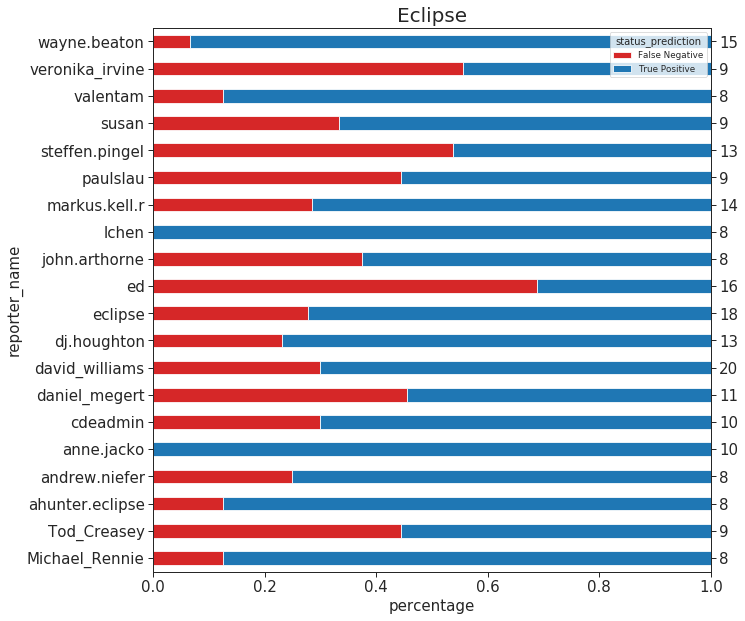

In [156]:
plot_bar('Eclipse', results_eclipse_merged_data, 'reporter_name',20)

### Assignee

### GCC

<Figure size 1440x1440 with 0 Axes>

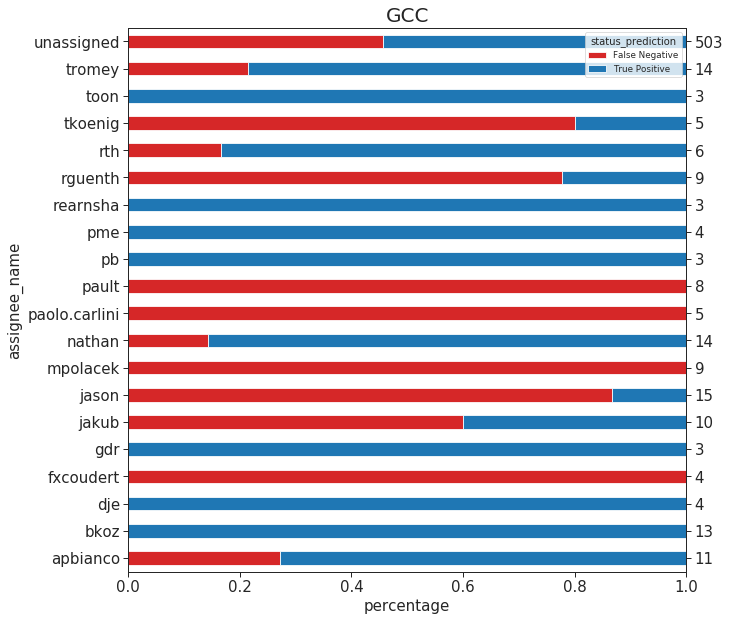

In [157]:
plot_bar('GCC', results_gcc_merged_data, 'assignee_name',20)

### Eclipse

<Figure size 1440x1440 with 0 Axes>

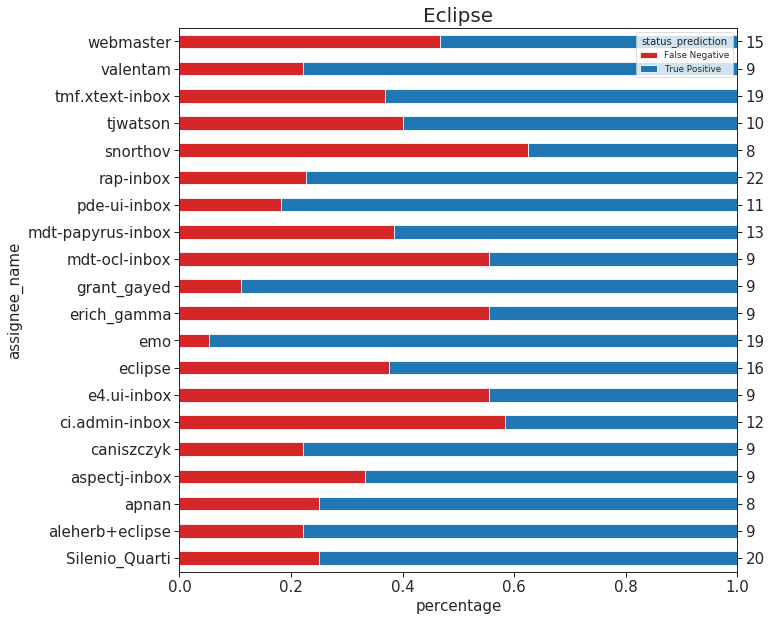

In [158]:
plot_bar('Eclipse', results_eclipse_merged_data, 'assignee_name',20)

### Component Name

### GCC

<Figure size 1440x1440 with 0 Axes>

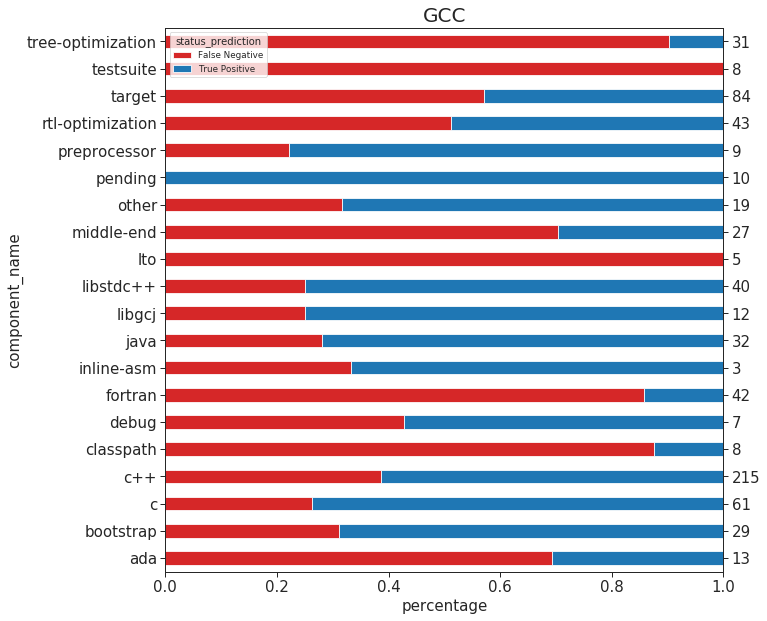

In [159]:
plot_bar('GCC', results_gcc_merged_data, 'component_name',20)

### Eclipse

<Figure size 1440x1440 with 0 Axes>

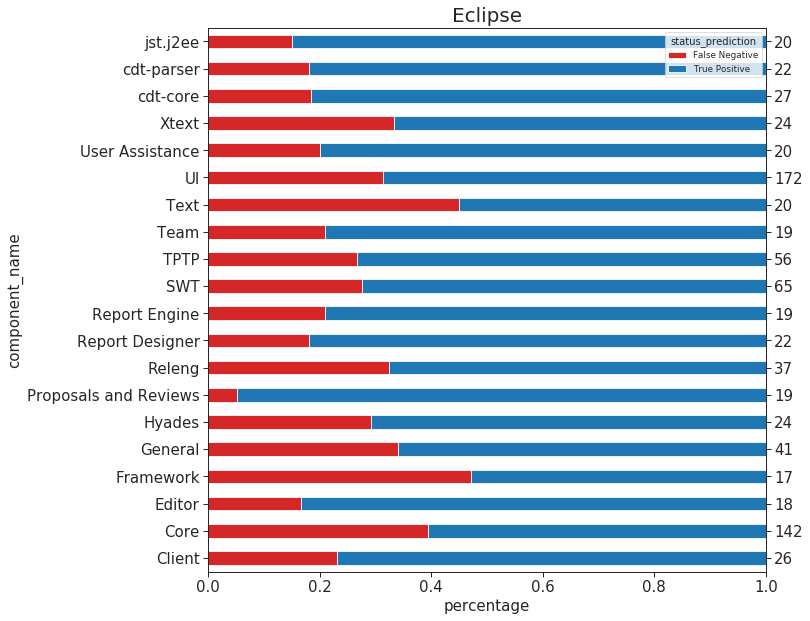

In [160]:
plot_bar('Eclipse', results_eclipse_merged_data, 'component_name',20)

### Severity Level

### GCC

<Figure size 1440x1440 with 0 Axes>

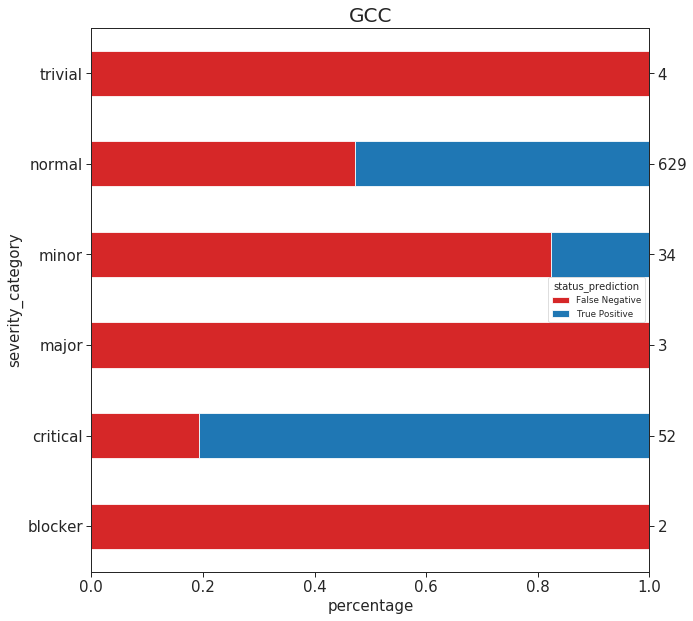

In [161]:
plot_bar('GCC', results_gcc_merged_data, 'severity_category',10)


### Eclipse

<Figure size 1440x1440 with 0 Axes>

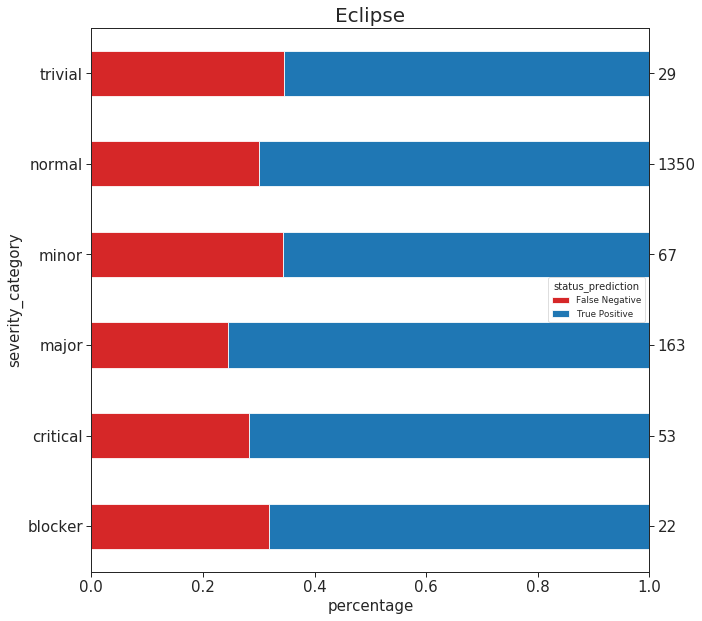

In [162]:
plot_bar('Eclipse', results_eclipse_merged_data, 'severity_category',10)

### Description 
Existem muitas palavras relacionadas com código(stop words).

In [28]:
word_frequency_gcc_path     = "datasets/20191210_gcc_tdm_summarized.csv"
word_frequency_eclipse_path = "datasets/20191210_eclipse_tdm_summarized.csv"

word_frequency_gcc_data     = pd.read_csv(word_frequency_gcc_path) 
word_frequency_eclipse_data = pd.read_csv(word_frequency_eclipse_path)

word_frequency_eclipse_data.dropna(inplace=True)
word_frequency_gcc_data.dropna(inplace=True)

word_frequency_gcc_data['freq'] = word_frequency_gcc_data['freq'].astype(int)
word_frequency_eclipse_data['freq'] = word_frequency_eclipse_data['freq'].astype(int)

tdm_detailed_eclipse_path = "datasets/20191210_eclipse_tdm_detailed.csv"
tdm_detailed_gcc_path     = "datasets/20191210_gcc_tdm_detailed.csv"

tdm_detailed_eclipse_data = pd.read_csv(tdm_detailed_eclipse_path) 
tdm_detailed_gcc_data     = pd.read_csv(tdm_detailed_gcc_path)

tdm_detailed_eclipse_data.dropna(inplace=True)
tdm_detailed_gcc_data.dropna(inplace=True)

In [29]:
from PIL import Image
import matplotlib
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
def plot_word_cloud(data, status):
    data = data[data['status_prediction']==status]
    #cloud_mask = np.array(Image.open("cloud.png"))
    
    word_frequency = {x[0]: x[1] for x in data.itertuples(index=False)}
    
    wordcloud = WordCloud(width=900
                      , height=500
                      , background_color='white'
                      , max_words=100
                      , colormap=matplotlib.cm.inferno
                      , relative_scaling=1
                      , normalize_plurals=False).generate_from_frequencies(word_frequency)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")


### GCC

In [30]:
word_frequency_gcc_data.head()

,word,freq,status_prediction,project
0,lib,6,True Positive,gcc
1,includ,6,True Positive,gcc
2,linux,6,True Positive,gcc
3,usr,6,True Positive,gcc
4,int,6,True Positive,gcc


### True Positives

#### Word cloud

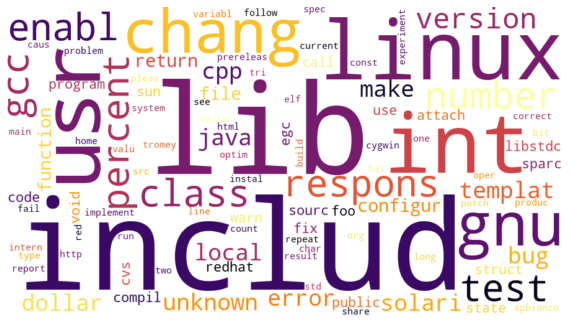

In [31]:
plot_word_cloud(word_frequency_gcc_data, 'True Positive')

#### Histograms 

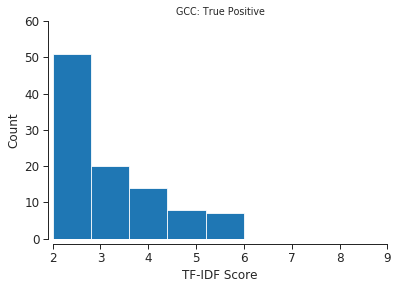

In [32]:
freqs=word_frequency_gcc_data[word_frequency_gcc_data['status_prediction']=='True Positive']['freq']

plt.hist(freqs, color='tab:blue', bins=5)
sns.despine(offset=5)

plt.title("GCC: True Positive")
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9], fontsize=SMALL_SIZE)
plt.xlim(2, 9)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=SMALL_SIZE)

plt.savefig('figures/rq5-gcc-tf-idf-histogram-true-positives.pdf', format="pdf", dpi=600, bbox_inches='tight')

In [52]:
from numpy import array
from numpy import count_nonzero
import numpy as np


def spy(m, ax):
    from scipy.sparse import coo_matrix
    from matplotlib.patches import Rectangle
    
    a = m.to_numpy()
    sparcity = 1.0 - ( count_nonzero(a) / float(a.size) )
    
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    for (x, y) in zip(m.col, m.row):
        ax.add_artist(Rectangle(
            xy=(x-0.5, y-0.5), width=1, height=1))
    ax.set_xlim(-0.5, m.shape[1]-0.5)
    ax.set_ylim(-0.5, m.shape[0]-0.5)
    ax.invert_yaxis()
    ax.set_aspect(float(m.shape[0])/float(m.shape[1]))
    ax.set_title(f"Sparcity : {sparcity}")

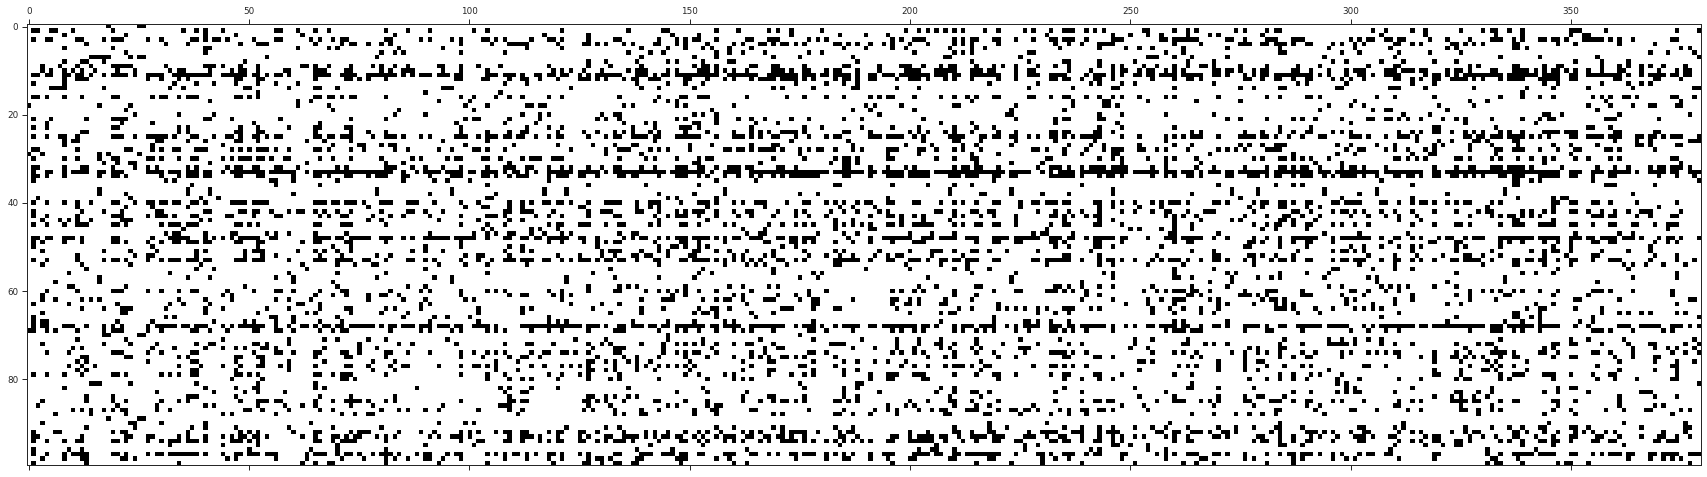

In [53]:
tdm_detailed_gcc_matrix = tdm_detailed_gcc_data.loc[tdm_detailed_gcc_data.status_prediction=='True Positive'].pivot_table(index='Terms', columns='Docs', values='value', fill_value=0.0)
fig, ax = plt.subplots(figsize=(30, 20))
ax.spy(tdm_detailed_gcc_matrix)

In [54]:
m = tdm_detailed_gcc_matrix.to_numpy()
sparsity = 1.0 - ( count_nonzero(m) / float(m.size) )
sparsity

0.821921052631579

### False Negatives
---

#### Word Cloud

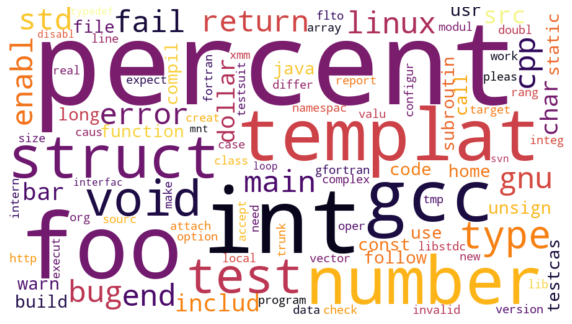

In [36]:
plot_word_cloud(word_frequency_gcc_data, 'False Negative')

#### Histogram

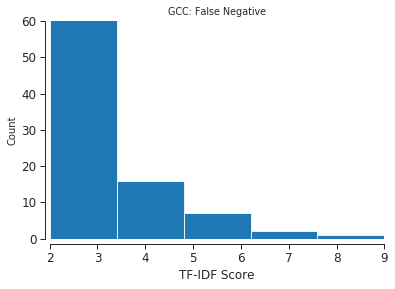

In [37]:
plt.hist(word_frequency_gcc_data[word_frequency_gcc_data['status_prediction']=='False Negative']['freq']
         , bins=5
         , color='tab:blue')
sns.despine(offset=5)
plt.title("GCC: False Negative")
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9], fontsize=SMALL_SIZE)
plt.xlim(2, 9)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=10)
plt.savefig('figures/rq5-gcc-tf-idf-histogram-false-negatives.pdf', format="pdf", dpi=600, bbox_inches='tight')

#### Sparcity

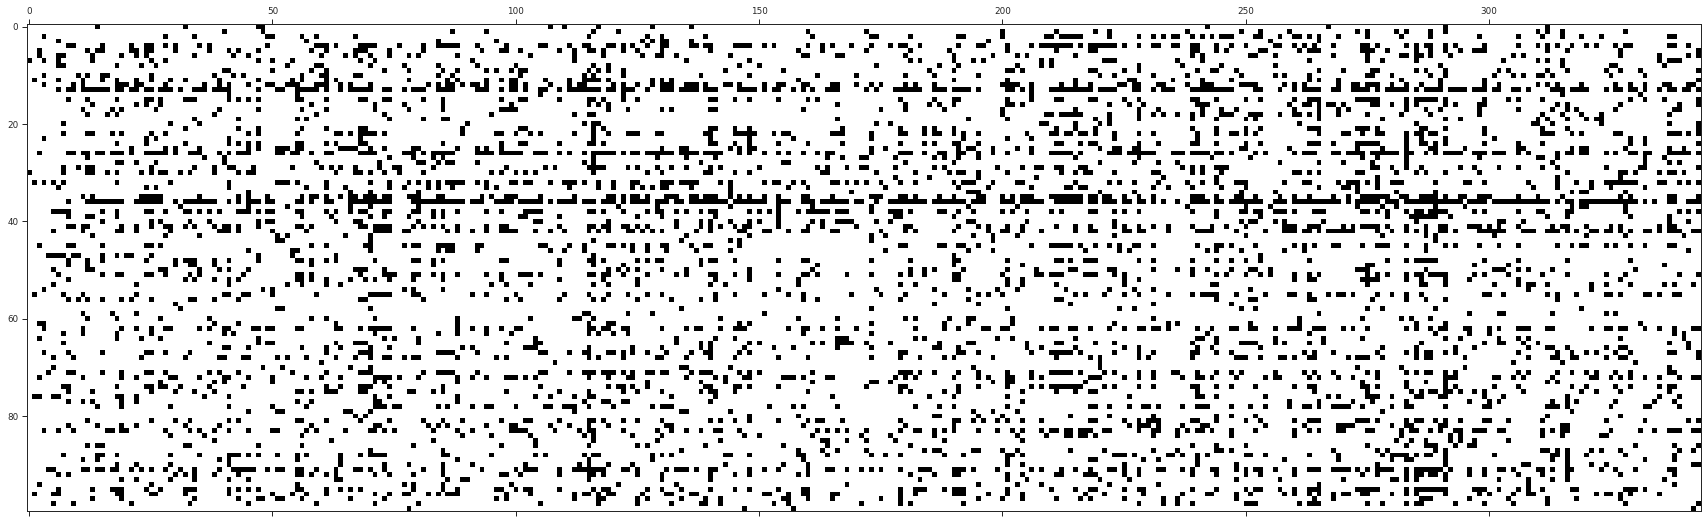

In [38]:
tdm_detailed_gcc_matrix = tdm_detailed_gcc_data.loc[tdm_detailed_gcc_data.status_prediction=='False Negative'].pivot_table(index='Terms', columns='Docs', values='value', fill_value=0.0)
fig, ax = plt.subplots(figsize=(30, 20))
ax.spy(tdm_detailed_gcc_matrix)

In [39]:
m = tdm_detailed_gcc_matrix.to_numpy()
sparsity = 1.0 - ( count_nonzero(m) / float(m.size) )
sparsity

0.8411918604651163

# Eclipse

### True Positives
-------------------

#### Word Cloud

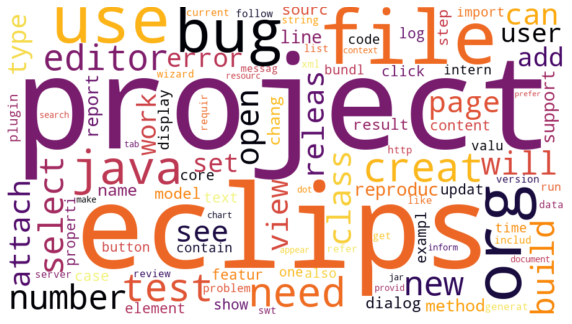

In [40]:
plot_word_cloud(word_frequency_eclipse_data, 'True Positive')

#### Histogram

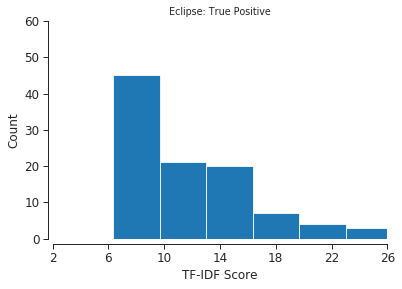

In [41]:
plt.hist(word_frequency_eclipse_data[word_frequency_eclipse_data['status_prediction']=='True Positive']['freq'].astype('int')
         , align='left'
         , bins=6
         , color='tab:blue')
sns.despine(offset=5)
plt.title("Eclipse: True Positive")
plt.xticks([2, 6, 10, 14, 18, 22, 26], fontsize=SMALL_SIZE)
plt.xlim(2, 26)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=SMALL_SIZE)
plt.savefig('figures/rq5-eclipse-tf-idf-histogram-true-positives.pdf', format="pdf", dpi=600, bbox_inches='tight')

#### Sparcity

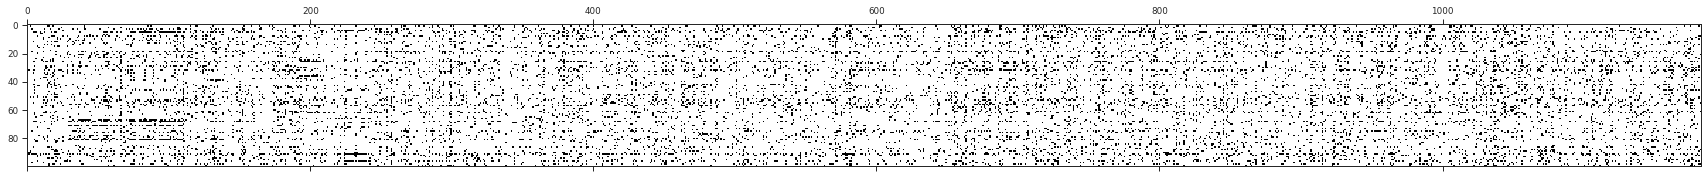

In [42]:
tdm_detailed_eclipse_matrix = tdm_detailed_eclipse_data.loc[tdm_detailed_eclipse_data.status_prediction=='True Positive'].pivot_table(index='Terms', columns='Docs', values='value', fill_value=0.0)
fig, ax = plt.subplots(figsize=(30, 20))
ax.spy(tdm_detailed_eclipse_matrix)

In [43]:
m = tdm_detailed_eclipse_matrix.to_numpy()
sparsity = 1.0 - ( count_nonzero(m) / float(m.size) )
sparsity

0.894683009298394

### False Negatives
---

#### Word Cloud

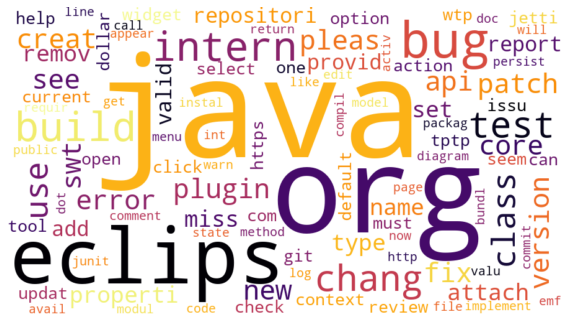

In [44]:
plot_word_cloud(word_frequency_eclipse_data, 'False Negative')

#### Histogram

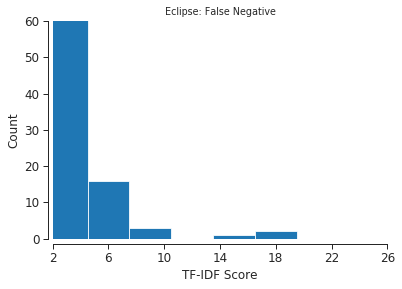

In [45]:
plt.hist(word_frequency_eclipse_data[word_frequency_eclipse_data['status_prediction']=='False Negative']['freq']
         , align='left'
         , bins=6
         , color='tab:blue')
sns.despine(offset=5)
plt.title("Eclipse: False Negative")
plt.xticks([2, 6, 10, 14, 18, 22, 26], fontsize=SMALL_SIZE)
plt.xlim(2, 26)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=SMALL_SIZE)
plt.savefig('figures/rq5-eclipse-tf-idf-histogram-false-negatives.pdf', format="pdf", dpi=600, bbox_inches='tight')

#### Sparcity

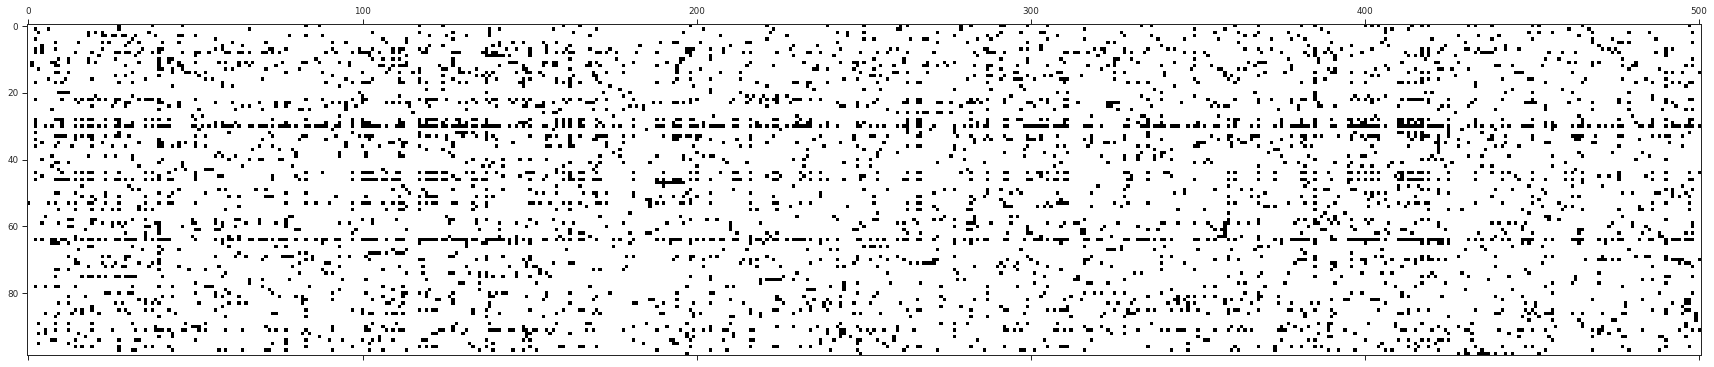

In [46]:
tdm_detailed_eclipse_matrix = tdm_detailed_eclipse_data.loc[tdm_detailed_eclipse_data.status_prediction=='False Negative'].pivot_table(index='Terms', columns='Docs', values='value', fill_value=0.0)
fig, ax = plt.subplots(figsize=(30, 20))
ax.spy(tdm_detailed_eclipse_matrix)

In [47]:
m = tdm_detailed_eclipse_matrix.to_numpy()
sparsity = 1.0 - ( count_nonzero(m) / float(m.size) )
sparsity

0.9087481602451662